# 05: Multiple-Patch Model Training
This script implements uniform patching, patch-level training with sample weights, and painting-level aggregation.

## 1. Imports & Dependencies
(imports os, numpy, torch, torchvision, timm, PIL, GroupShuffleSplit)

In [1]:
#1. Import dependencies
import os, numpy as np, torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms
import timm
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import GroupShuffleSplit
import torch.nn.utils as U
from collections import defaultdict, Counter
import json
from datetime import datetime
from torch.utils.data import Dataset
from torchvision import transforms
import torch 
from timm.scheduler import CosineLRScheduler
import pandas as pd
from pathlib import Path


## 2. Define dataset class producing all patches
(class MultiPatchDataset)

In [2]:

class MultiPatchDataset(Dataset):
    def __init__(self, root_dir, target_size=256, imitation_weight=1.0):
        self.root_dir = root_dir
        self.target_size = target_size
        self.imitation_weight = imitation_weight
        self.defined_classes = ['authentic', 'imitation'] # authentic=0, imitation=1
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.defined_classes)}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        print(f"Dataset initialized. Root: '{self.root_dir}', Class mapping: {self.class_to_idx}")

        self.all_patches = [] # Will store (PIL.Image, label, painting_id)
        self._prepare_data()

        self.transform = transforms.Compose([
            transforms.Resize((self.target_size, self.target_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _prepare_data(self):
        painting_id_counter = 0
        for class_name in self.defined_classes:
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_path):
                print(f"Warning: Class directory not found: {class_path}")
                continue

            label = self.class_to_idx[class_name]
            
            image_files = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            if not image_files:
                print(f"Warning: No image files found in {class_path}")
                continue

            for img_filename in image_files:
                img_path = os.path.join(class_path, img_filename)
                current_painting_id = painting_id_counter # All patches from this image get this ID

                try:
                    img = Image.open(img_path).convert('RGB')
                    w, h = img.size
                    max_dim = max(w, h)

                    if max_dim == 0: # Skip zero-size images
                        print(f"Warning: Image {img_path} has zero dimension, skipping.")
                        continue

                    if max_dim > 1024:
                        grid_size = 4  # 4x4 patches
                    elif max_dim >= 512:
                        grid_size = 2  # 2x2 patches
                    else:
                        grid_size = 1  # 1x1 patch

                    patch_width = w // grid_size
                    patch_height = h // grid_size

                    if patch_width == 0 or patch_height == 0: # Skip if patches would be zero-size
                         print(f"Warning: Calculated patch size is zero for {img_path} (w={w},h={h},grid={grid_size}), skipping.")
                         continue

                    for i in range(grid_size):
                        for j in range(grid_size):
                            left = j * patch_width
                            upper = i * patch_height
                            # For the last patch in a row/column, extend to the image edge
                            right = (j + 1) * patch_width if (j + 1) < grid_size else w
                            bottom = (i + 1) * patch_height if (i + 1) < grid_size else h
                            
                            patch_img = img.crop((left, upper, right, bottom))
                            if patch_img.size[0] > 0 and patch_img.size[1] > 0: # Ensure patch is not empty
                                self.all_patches.append((patch_img, label, current_painting_id))
                            else:
                                print(f"Warning: Generated empty patch for {img_path} at grid ({i},{j}), skipping.")
                    
                    painting_id_counter += 1 # Increment for the next distinct artwork

                except UnidentifiedImageError:
                    print(f"Warning: Cannot identify image file {img_path}, skipping.")
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
        
        if not self.all_patches:
            print(f"Warning: No patches were generated. Check dataset structure in '{self.root_dir}', paths, and image files.")
        else:
            print(f"Generated {len(self.all_patches)} patches from {painting_id_counter} paintings.")


    def __len__(self):
        return len(self.all_patches)

    def __getitem__(self, idx):
        patch_img, label, painting_id = self.all_patches[idx]
        
        try:
            transformed_patch = self.transform(patch_img)
        except Exception as e:
            print(f"Error transforming patch (original index {idx}, painting_id {painting_id}): {e}")
            # Return a dummy tensor
            transformed_patch = torch.zeros((3, self.target_size, self.target_size), dtype=torch.float32)
            # Keep original label and painting_id
            
        return transformed_patch, label, painting_id

## 3. Define Device, Prepare Dataset & Splits, Calculate Class Weights

In [3]:
# 05: Multiple-Patch Model Training with 70/15/15 Split
# This script implements uniform patching, patch-level training with sample weights, and painting-level aggregation.
# Modified to use 70% train, 15% validation, 15% test split with test set isolation.

# 1. Imports & Dependencies
import os, numpy as np, torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms
import timm
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import GroupShuffleSplit
import torch.nn.utils as U
from collections import defaultdict, Counter
import json
from datetime import datetime
from torch.utils.data import Dataset
from torchvision import transforms
import torch # For dummy tensor in __getitem__ error handling
from timm.scheduler import CosineLRScheduler
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    accuracy_score
)

# 2. Define dataset class producing all patches
class MultiPatchDataset(Dataset):
    def __init__(self, root_dir, target_size=256, imitation_weight=1.0):
        self.root_dir = root_dir
        self.target_size = target_size
        self.imitation_weight = imitation_weight
        self.defined_classes = ['authentic', 'imitation'] # authentic=0, imitation=1
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.defined_classes)}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        print(f"Dataset initialized. Root: '{self.root_dir}', Class mapping: {self.class_to_idx}")

        self.all_patches = [] # Will store (PIL.Image, label, painting_id)
        self._prepare_data()

        self.transform = transforms.Compose([
            transforms.Resize((self.target_size, self.target_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _prepare_data(self):
        painting_id_counter = 0
        for class_name in self.defined_classes:
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_path):
                print(f"Warning: Class directory not found: {class_path}")
                continue

            label = self.class_to_idx[class_name]
            
            image_files = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            if not image_files:
                print(f"Warning: No image files found in {class_path}")
                continue

            for img_filename in image_files:
                img_path = os.path.join(class_path, img_filename)
                current_painting_id = painting_id_counter # All patches from this image get this ID

                try:
                    img = Image.open(img_path).convert('RGB')
                    w, h = img.size
                    max_dim = max(w, h)

                    if max_dim == 0: # Skip zero-size images
                        print(f"Warning: Image {img_path} has zero dimension, skipping.")
                        continue

                    if max_dim > 1024:
                        grid_size = 4  # 4x4 patches
                    elif max_dim >= 512:
                        grid_size = 2  # 2x2 patches
                    else:
                        grid_size = 1  # 1x1 patch

                    patch_width = w // grid_size
                    patch_height = h // grid_size

                    if patch_width == 0 or patch_height == 0: # Skip if patches would be zero-size
                         print(f"Warning: Calculated patch size is zero for {img_path} (w={w},h={h},grid={grid_size}), skipping.")
                         continue

                    for i in range(grid_size):
                        for j in range(grid_size):
                            left = j * patch_width
                            upper = i * patch_height
                            # For the last patch in a row/column, extend to the image edge
                            right = (j + 1) * patch_width if (j + 1) < grid_size else w
                            bottom = (i + 1) * patch_height if (i + 1) < grid_size else h
                            
                            patch_img = img.crop((left, upper, right, bottom))
                            if patch_img.size[0] > 0 and patch_img.size[1] > 0: # Ensure patch is not empty
                                self.all_patches.append((patch_img, label, current_painting_id))
                            else:
                                print(f"Warning: Generated empty patch for {img_path} at grid ({i},{j}), skipping.")
                    
                    painting_id_counter += 1 # Increment for the next distinct artwork

                except UnidentifiedImageError:
                    print(f"Warning: Cannot identify image file {img_path}, skipping.")
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
        
        if not self.all_patches:
            print(f"Warning: No patches were generated. Check dataset structure in '{self.root_dir}', paths, and image files.")
        else:
            print(f"Generated {len(self.all_patches)} patches from {painting_id_counter} paintings.")

    def __len__(self):
        return len(self.all_patches)

    def __getitem__(self, idx):
        patch_img, label, painting_id = self.all_patches[idx]
        
        try:
            transformed_patch = self.transform(patch_img)
        except Exception as e:
            print(f"Error transforming patch (original index {idx}, painting_id {painting_id}): {e}")
            # Return a dummy tensor
            transformed_patch = torch.zeros((3, self.target_size, self.target_size), dtype=torch.float32)
            # Keep original label and painting_id
            
        return transformed_patch, label, painting_id

# 3. Define Device, Prepare Dataset & Splits (70/15/15), Calculate Class Weights

# Define device at the beginning
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

root_dir = '/kaggle/input/vangogh-run1/run_1'  # adjust path as needed
ds = MultiPatchDataset(root_dir, target_size=256, imitation_weight=1.0)
groups = [pid for _, _, pid in ds.all_patches]

# Modified splitting with GroupShuffleSplit for 70/15/15 split
# First split: 70% train, 30% temp (which will be split into 15% val, 15% test)
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(gss1.split(ds.all_patches, groups=groups))

# Second split: Split the 30% temp into 15% val and 15% test (50/50 of the temp)
temp_groups = [groups[i] for i in temp_idx]
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=43)
val_idx_temp, test_idx_temp = next(gss2.split([ds.all_patches[i] for i in temp_idx], groups=temp_groups))

# Map back to original indices
val_idx = [temp_idx[i] for i in val_idx_temp]
test_idx = [temp_idx[i] for i in test_idx_temp]

print(f"Train samples: {len(train_idx)} ({len(train_idx)/len(ds.all_patches)*100:.1f}%)")
print(f"Val samples: {len(val_idx)} ({len(val_idx)/len(ds.all_patches)*100:.1f}%)")
print(f"Test samples: {len(test_idx)} ({len(test_idx)/len(ds.all_patches)*100:.1f}%)")
print(f"Classes: {list(ds.class_to_idx.keys())}")

# Excel tracking function with train/val/test flags
excel_path = "/kaggle/input/excel-file-images/vg_cv_data_july31_updated.xlsx"  
sheet_name = 'vg_cv_data_july31'

def track_split_during_processing(excel_path, sheet_name, root_dir, ds, train_idx, val_idx, test_idx):
    print("Updating Excel file with train/val/test split...")
    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    
    df['run_1_split'] = ''
    
    painting_id_to_info = {}
    painting_id_counter = 0
    
    for class_name in ds.defined_classes:
        class_path = Path(root_dir) / class_name
        if not class_path.is_dir():
            continue
            
        image_files = sorted([f for f in class_path.iterdir() 
                            if f.suffix.lower() in ('.png', '.jpg', '.jpeg')])
        
        for img_file in image_files:
            painting_id_to_info[painting_id_counter] = img_file.name
            painting_id_counter += 1
    
    train_painting_ids = {ds.all_patches[idx][2] for idx in train_idx}
    val_painting_ids = {ds.all_patches[idx][2] for idx in val_idx}
    test_painting_ids = {ds.all_patches[idx][2] for idx in test_idx}
    
    train_filenames = {painting_id_to_info[pid] for pid in train_painting_ids if pid in painting_id_to_info}
    val_filenames = {painting_id_to_info[pid] for pid in val_painting_ids if pid in painting_id_to_info}
    test_filenames = {painting_id_to_info[pid] for pid in test_painting_ids if pid in painting_id_to_info}

    for idx, row in df.iterrows():
        image_filename = row['image']
        if image_filename in train_filenames:
            df.loc[idx, 'run_1_split'] = 'train'
        elif image_filename in val_filenames:
            df.loc[idx, 'run_1_split'] = 'val'
        elif image_filename in test_filenames:
            df.loc[idx, 'run_1_split'] = 'test'
    
    # Save updated file
    output_path = '/kaggle/working/vg_cv_data_july31_v1_with_train_val_test_split.xlsx'
    df.to_excel(output_path, sheet_name=sheet_name, index=False)
    
    split_counts = df['run_1_split'].value_counts()
    print(f"Updated Excel saved to: {output_path}")
    print(f"Train/Val/Test split: {dict(split_counts)}")
    
    return output_path

updated_excel = track_split_during_processing(
    excel_path=excel_path,
    sheet_name=sheet_name,
    root_dir=root_dir,
    ds=ds,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx
)


train_dataset = Subset(ds, train_idx)
val_dataset = Subset(ds, val_idx)
test_dataset = Subset(ds, test_idx)  # Reserved for final evaluation only

print(f"Test dataset created with {len(test_dataset)} samples but will NOT be used during training.")


train_labels_for_sampler = np.array([ds.all_patches[i][1] for i in train_idx])
weights = [ds.imitation_weight if label == ds.class_to_idx.get('imitation', 1) else 1 for label in train_labels_for_sampler]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)


train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # Not used during training

# Calculate class_weights for loss_fn (only from training set)
train_labels_for_class_weights = [ds.all_patches[i][1] for i in train_idx]
class_counts = Counter(train_labels_for_class_weights)
num_classes = len(ds.class_to_idx)

print(f"DEBUG: ds.class_to_idx: {ds.class_to_idx}")
print(f"DEBUG: num_classes: {num_classes}")
print(f"DEBUG: class_counts: {class_counts}")

weights_list = [0.0] * num_classes 

for class_idx, count in class_counts.items():
    if count > 0:
        weights_list[class_idx] = len(train_labels_for_class_weights) / (num_classes * count)
    else:
        weights_list[class_idx] = 1.0

class_weights = torch.tensor(weights_list, dtype=torch.float).to(device)
print(f"Calculated class weights: {class_weights.tolist()}")

Using device: cuda
Dataset initialized. Root: '/kaggle/input/vangogh-run1/run_1', Class mapping: {'authentic': 0, 'imitation': 1}
Generated 20818 patches from 1507 paintings.
Train samples: 14602 (70.1%)
Val samples: 3076 (14.8%)
Test samples: 3140 (15.1%)
Classes: ['authentic', 'imitation']
Updating Excel file with train/val/test split...
Updated Excel saved to: /kaggle/working/vg_cv_data_july31_v1_with_train_val_test_split.xlsx
Train/Val/Test split: {'': 1438, 'train': 1054, 'val': 227, 'test': 227}
Test dataset created with 3140 samples but will NOT be used during training.
DEBUG: ds.class_to_idx: {'authentic': 0, 'imitation': 1}
DEBUG: num_classes: 2
DEBUG: class_counts: Counter({0: 7633, 1: 6969})
Calculated class weights: [0.9565046429634094, 1.0476394891738892]


## 4. Model Setup (EfficientNet & Swin)

In [4]:
# 4. Model Setup (EfficientNet & Swin with DLR for Swin)
print("--- Setting up models and optimizers ---")

models = {}
models['efficientnet'] = timm.create_model('efficientnet_b5', pretrained=True, num_classes=2).to(device)
models['swin'] = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2, img_size=256).to(device) # img_size=256 as per your setup

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights) # Assuming class_weights is defined and on device

# Optimizer for EfficientNet (remains the same or as per your best settings)
eff_optimizer = torch.optim.AdamW(models['efficientnet'].parameters(), lr=1e-5, weight_decay=1e-2)

# --- Differential Learning Rate Setup for Swin Transformer ---
swin_model_instance = models['swin']

# Define Learning Rates for the initial (Frozen Backbone) phase
lr_head_frozen_swin = 3e-5       # Initial LR for the Swin head
lr_backbone_frozen_swin = 0.0    # Backbone is frozen

try:
    # For swin_tiny_patch4_window7_224, the classifier is typically 'head'
    head_params_swin = list(swin_model_instance.head.parameters())
    head_param_ids_swin = {id(p) for p in head_params_swin}
    backbone_params_swin = [p for p in swin_model_instance.parameters() if id(p) not in head_param_ids_swin]

    if not backbone_params_swin:
        print("Warning: Swin backbone parameters list is empty. Check model structure ('head'). Falling back.")
        # Fallback: all params trainable with head_lr
        for param in swin_model_instance.parameters():
            param.requires_grad = True
        swin_optimizer = torch.optim.AdamW(swin_model_instance.parameters(), lr=lr_head_frozen_swin, weight_decay=1e-2)
    else:
        # Freeze backbone layers initially
        for param in backbone_params_swin:
            param.requires_grad = False
        # Ensure head is trainable
        for param in head_params_swin:
            param.requires_grad = True

        swin_optimizer = torch.optim.AdamW([
            {'params': backbone_params_swin, 'lr': lr_backbone_frozen_swin, 'name': 'swin_backbone'},
            {'params': head_params_swin, 'lr': lr_head_frozen_swin, 'name': 'swin_head'}
        ], weight_decay=1e-2) # Using 1e-2 weight decay as per your original Swin optimizer
        print("Swin Transformer Optimizer (Frozen Backbone Phase - DLR) configured.")

except AttributeError:
    print("Error: swin_model_instance.head not found. Cannot separate head/backbone for Swin DLRs automatically.")
    print("Falling back to a single learning rate for all Swin parameters.")
    for param in swin_model_instance.parameters(): # Ensure all params are trainable if fallback
        param.requires_grad = True
    swin_optimizer = torch.optim.AdamW(swin_model_instance.parameters(), lr=lr_head_frozen_swin, weight_decay=1e-2)

optimizers = {
    'efficientnet': eff_optimizer,
    'swin': swin_optimizer
}

# Print optimizer details for verification
for model_name, optimizer in optimizers.items():
    print(f"\nOptimizer for {model_name}:")
    if optimizer: # Check if optimizer was successfully created
        for i, param_group in enumerate(optimizer.param_groups):
            group_name = param_group.get('name', f'group_{i}')
            num_params_in_group = sum(p.numel() for p in param_group['params'] if p.requires_grad)
            total_params_in_group = sum(p.numel() for p in param_group['params'])
            print(f"  Group: {group_name}, LR: {param_group['lr']}, Trainable Params: {num_params_in_group}/{total_params_in_group}, Num Tensors: {len(param_group['params'])}")
            if len(param_group['params']) > 0:
                 print(f"    Sample param requires_grad: {param_group['params'][0].requires_grad}")
    else:
        print(f"  Optimizer for {model_name} not configured (likely due to an error).")
print("--- Model and optimizer setup complete ---")

--- Setting up models and optimizers ---


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Swin Transformer Optimizer (Frozen Backbone Phase - DLR) configured.

Optimizer for efficientnet:
  Group: group_0, LR: 1e-05, Trainable Params: 28344882/28344882, Num Tensors: 506
    Sample param requires_grad: True

Optimizer for swin:
  Group: swin_backbone, LR: 0.0, Trainable Params: 0/27519354, Num Tensors: 171
    Sample param requires_grad: False
  Group: swin_head, LR: 3e-05, Trainable Params: 1538/1538, Num Tensors: 2
    Sample param requires_grad: True
--- Model and optimizer setup complete ---


## 5. Logging & Model‐Saving Setup
(make log directory, define timestamp, model_save_paths, log_paths, and log_metrics function)

In [5]:
 
# Ensure log directory exists
os.makedirs('/kaggle/working/Training Data', exist_ok=True)
now_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Define save paths (log_paths removed)
model_save_paths = {
    "efficientnet": f"/kaggle/working/model/efficientnet_b5_finetuned_{now_str}_run1.pth",
    "swin": f"/kaggle/working/model/swin_tiny_patch4_window7_224_finetuned_{now_str}_run1.pth"
}

## 6. Function: save_training_results
(defines saving detailed training/validation metrics to JSON)

In [6]:
def save_training_results(model_name, train_metrics, val_metrics, now_str):
    """Save detailed training results to a JSON file"""
    results = {
        "model_name": model_name,
        "timestamp": now_str,
        "training": train_metrics,
        "validation": val_metrics
    }
    json_path = f"/kaggle/working/Training Data/{model_name}_results_{now_str}_run1.json"
    with open(json_path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Detailed results saved to {json_path}")

In [7]:
# 6a. Enhanced train_one_epoch with console logging
def train_one_epoch(model, loader, optimizer, epoch=None, print_every=10):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []

    for batch_idx, (x, y, _) in enumerate(loader, start=1):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()

        # clip & capture the norm in one step
        #grad_norm = U.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Use a higher max_norm for Swin, standard for others
        if hasattr(model, 'default_cfg') and 'swin' in model.default_cfg.get('architecture', '').lower():
            grad_norm = U.clip_grad_norm_(model.parameters(), max_norm=5.0)
        else:
            grad_norm = U.clip_grad_norm_(model.parameters(), max_norm=1.0)
        #print(f"Gradient magnitude: {grad_norm:.6f}")

        optimizer.step()
        total_loss += loss.item() * x.size(0)

        preds = out.argmax(dim=1).cpu().tolist()
        all_preds .extend(preds)
        all_labels.extend(y.cpu().tolist())

        if epoch is not None and batch_idx % print_every == 0:
            print(f"Epoch {epoch+1} | Batch {batch_idx}/{len(loader)} | Loss {loss.item():.6f}")

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, all_labels, all_preds

## 7. Evaluation with painting-level aggregation
(eval_dataset using defaultdict to average patch logits)

In [8]:
# 7. Evaluation with painting-level aggregation

def eval_dataset_with_loss(model, loader, loss_fn):
    model.eval()
    group_logits = defaultdict(list)
    group_labels = {}
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for x, y, pid in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            
            # Calculate loss for this batch
            batch_loss = loss_fn(logits, y)
            total_loss += batch_loss.item() * x.size(0)
            total_samples += x.size(0)
            
            # Continue with painting-level aggregation
            logits_cpu = logits.cpu()
            for lg, yy, id_ in zip(logits_cpu, y.cpu(), pid):
                group_logits[id_].append(lg)
                group_labels[id_] = int(yy)

    # Calculate average loss
    avg_loss = total_loss / total_samples
    
    # Sample predictions (first 5)
    for pid, lgs in list(group_logits.items())[:5]:
        avg = torch.stack(lgs).mean(0)
        print(f"Painting {pid}: logits={avg.tolist()}, pred={int(avg.argmax())}, true={group_labels[pid]}")

    # Class balance print
    y_true = list(group_labels.values())
    print(f"Validation class distribution: {sum(y_true)}/{len(y_true)} positives")

    # Compute painting-level accuracy
    y_pred = [int(torch.stack(lgs).mean(0).argmax()) for lgs in group_logits.values()]
    acc = sum(yt==yp for yt, yp in zip(y_true, y_pred)) / len(y_true)
    
    return acc, avg_loss

## 8. Training loop (patch-level)
(defines train_one_epoch and loops over models to train, log, save checkpoints, and call save_training_results)

--- Configuring Schedulers ---
  Configured ReduceLROnPlateau for 'efficientnet'.
  Scheduler for 'swin' will be initialized during unfreeze.
--- Schedulers configured ---

--- Verifying Initial Swin Model State (Pre-Epoch 0) ---
  Checking requires_grad for Swin model params...
  Verifying Swin optimizer groups LRs and param_requires_grad...
  Swin initial state verification complete.

--- Starting Training for 30 Epochs ---

===== EPOCH 1/30 =====

Training efficientnet for Epoch 1...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 | Batch 50/913 | Loss 2.057062
Epoch 1 | Batch 100/913 | Loss 0.770432
Epoch 1 | Batch 150/913 | Loss 2.427919
Epoch 1 | Batch 200/913 | Loss 0.076489
Epoch 1 | Batch 250/913 | Loss 1.783429
Epoch 1 | Batch 300/913 | Loss 0.398401
Epoch 1 | Batch 350/913 | Loss 0.175135
Epoch 1 | Batch 400/913 | Loss 0.164494
Epoch 1 | Batch 450/913 | Loss 1.584247
Epoch 1 | Batch 500/913 | Loss 0.024249
Epoch 1 | Batch 550/913 | Loss 0.059290
Epoch 1 | Batch 600/913 | Loss 0.032629
Epoch 1 | Batch 650/913 | Loss 0.180019
Epoch 1 | Batch 700/913 | Loss 0.346143
Epoch 1 | Batch 750/913 | Loss 0.024711
Epoch 1 | Batch 800/913 | Loss 0.970719
Epoch 1 | Batch 850/913 | Loss 0.197045
Epoch 1 | Batch 900/913 | Loss 0.674131
Validating efficientnet for Epoch 1...
RESULTS: efficientnet | Epoch 1/30 | Train Loss: 0.755556 | Val Acc: 0.908322

Training swin for Epoch 1...
  Current LRs for swin:
    Group 'swin_backbone': 0.00e+00
    Group 'swin_head': 3.00e-05
Epoch 1 | Batch 50/913 | Loss 0.797265
Epo

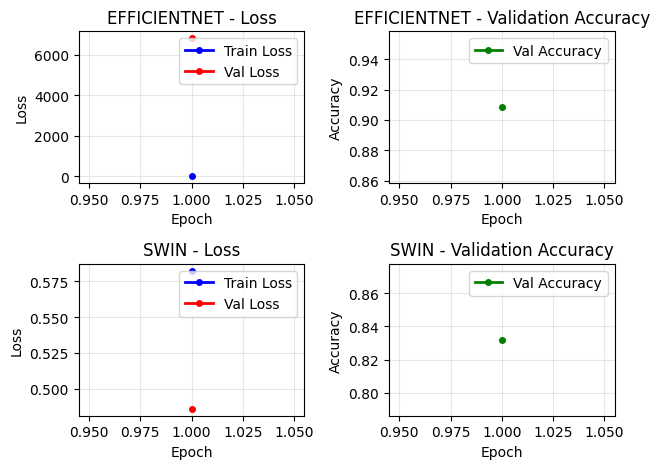


===== EPOCH 2/30 =====

Training efficientnet for Epoch 2...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 2 | Batch 50/913 | Loss 0.019283
Epoch 2 | Batch 100/913 | Loss 1.298095
Epoch 2 | Batch 150/913 | Loss 0.067802
Epoch 2 | Batch 200/913 | Loss 1.749957
Epoch 2 | Batch 250/913 | Loss 0.061155
Epoch 2 | Batch 300/913 | Loss 0.053613
Epoch 2 | Batch 350/913 | Loss 0.090403
Epoch 2 | Batch 400/913 | Loss 0.046130
Epoch 2 | Batch 450/913 | Loss 0.153037
Epoch 2 | Batch 500/913 | Loss 0.004836
Epoch 2 | Batch 550/913 | Loss 0.000344
Epoch 2 | Batch 600/913 | Loss 0.229947
Epoch 2 | Batch 650/913 | Loss 0.224190
Epoch 2 | Batch 700/913 | Loss 0.000501
Epoch 2 | Batch 750/913 | Loss 0.414794
Epoch 2 | Batch 800/913 | Loss 0.252622
Epoch 2 | Batch 850/913 | Loss 0.545655
Epoch 2 | Batch 900/913 | Loss 0.000073
Validating efficientnet for Epoch 2...
RESULTS: efficientnet | Epoch 2/30 | Train Loss: 0.178128 | Val Acc: 0.932705

Training swin for Epoch 2...
  Current 

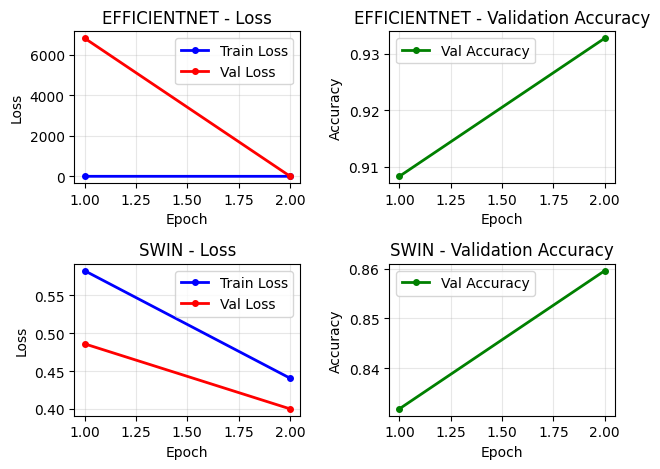


===== EPOCH 3/30 =====

Training efficientnet for Epoch 3...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 3 | Batch 50/913 | Loss 0.000029
Epoch 3 | Batch 100/913 | Loss 0.000196
Epoch 3 | Batch 150/913 | Loss 0.007842
Epoch 3 | Batch 200/913 | Loss 0.003141
Epoch 3 | Batch 250/913 | Loss 0.162887
Epoch 3 | Batch 300/913 | Loss 0.136862
Epoch 3 | Batch 350/913 | Loss 0.014553
Epoch 3 | Batch 400/913 | Loss 0.001437
Epoch 3 | Batch 450/913 | Loss 0.000007
Epoch 3 | Batch 500/913 | Loss 0.020766
Epoch 3 | Batch 550/913 | Loss 0.000108
Epoch 3 | Batch 600/913 | Loss 0.002469
Epoch 3 | Batch 650/913 | Loss 0.000027
Epoch 3 | Batch 700/913 | Loss 0.160968
Epoch 3 | Batch 750/913 | Loss 0.000836
Epoch 3 | Batch 800/913 | Loss 0.008334
Epoch 3 | Batch 850/913 | Loss 0.094217
Epoch 3 | Batch 900/913 | Loss 0.002430
Validating efficientnet for Epoch 3...
RESULTS: efficientnet | Epoch 3/30 | Train Loss: 0.132771 | Val Acc: 0.931079

Training swin for Epoch 3...
  Current 

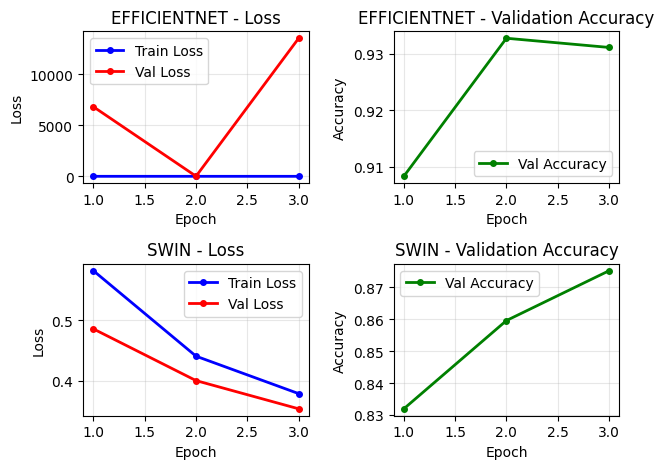


===== EPOCH 4/30 =====

Training efficientnet for Epoch 4...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 4 | Batch 50/913 | Loss 0.000014
Epoch 4 | Batch 100/913 | Loss 0.000663
Epoch 4 | Batch 150/913 | Loss 0.003753
Epoch 4 | Batch 200/913 | Loss 0.000012
Epoch 4 | Batch 250/913 | Loss 0.000047
Epoch 4 | Batch 300/913 | Loss 0.213191
Epoch 4 | Batch 350/913 | Loss 0.000201
Epoch 4 | Batch 400/913 | Loss 0.019987
Epoch 4 | Batch 450/913 | Loss 0.056554
Epoch 4 | Batch 500/913 | Loss 0.000015
Epoch 4 | Batch 550/913 | Loss 0.019909
Epoch 4 | Batch 600/913 | Loss 0.006976
Epoch 4 | Batch 650/913 | Loss 0.000006
Epoch 4 | Batch 700/913 | Loss 0.000174
Epoch 4 | Batch 750/913 | Loss 0.000471
Epoch 4 | Batch 800/913 | Loss 0.000033
Epoch 4 | Batch 850/913 | Loss 0.000000
Epoch 4 | Batch 900/913 | Loss 0.000327
Validating efficientnet for Epoch 4...
RESULTS: efficientnet | Epoch 4/30 | Train Loss: 0.100546 | Val Acc: 0.939532

Training swin for Epoch 4...
  Current 

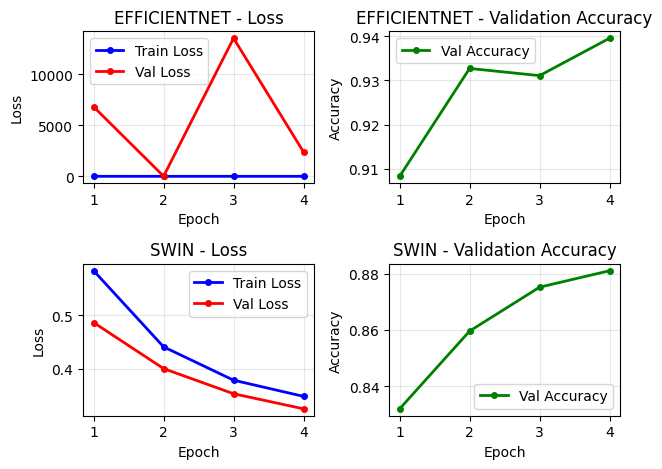


===== EPOCH 5/30 =====

Training efficientnet for Epoch 5...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 5 | Batch 50/913 | Loss 0.002934
Epoch 5 | Batch 100/913 | Loss 0.366794
Epoch 5 | Batch 150/913 | Loss 0.127260
Epoch 5 | Batch 200/913 | Loss 0.000310
Epoch 5 | Batch 250/913 | Loss 0.000024
Epoch 5 | Batch 300/913 | Loss 0.002237
Epoch 5 | Batch 350/913 | Loss 0.000003
Epoch 5 | Batch 400/913 | Loss 0.034392
Epoch 5 | Batch 450/913 | Loss 0.000798
Epoch 5 | Batch 500/913 | Loss 0.000586
Epoch 5 | Batch 550/913 | Loss 0.094825
Epoch 5 | Batch 600/913 | Loss 0.000017
Epoch 5 | Batch 650/913 | Loss 0.153902
Epoch 5 | Batch 700/913 | Loss 0.000045
Epoch 5 | Batch 750/913 | Loss 0.002519
Epoch 5 | Batch 800/913 | Loss 0.050611
Epoch 5 | Batch 850/913 | Loss 0.000095
Epoch 5 | Batch 900/913 | Loss 0.081281
Validating efficientnet for Epoch 5...
RESULTS: efficientnet | Epoch 5/30 | Train Loss: 0.069132 | Val Acc: 0.937906

Training swin for Epoch 5...
  Current 

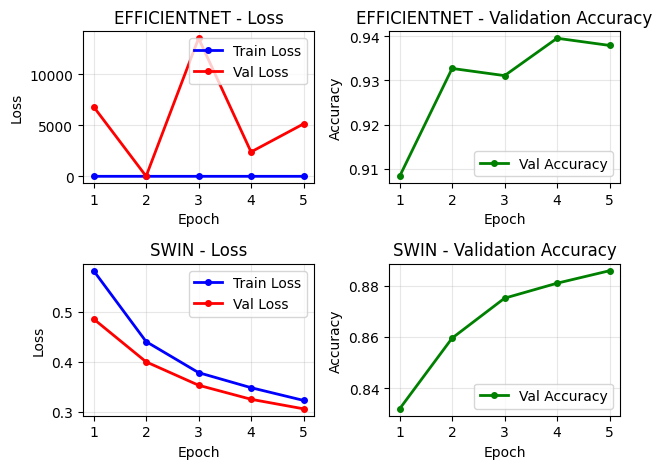


===== EPOCH 6/30 =====

-- Epoch 6: Unfreezing Swin Transformer backbone and adjusting LRs for fine-tuning. --
  Setting requires_grad=True for all Swin model parameters...
    All Swin model parameters set to requires_grad=True.
  LR for Swin group 'swin_backbone' set to: 3.00e-06
  LR for Swin group 'swin_head' set to: 8.00e-06
  Successfully updated LRs for Swin optimizer groups.
  Initializing CosineLRScheduler for Swin fine-tuning...
  Swin CosineLRScheduler initialized for 25 fine-tuning epochs.
-- Swin unfreezing and LR adjustment complete. --

Training efficientnet for Epoch 6...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 6 | Batch 50/913 | Loss 0.000002
Epoch 6 | Batch 100/913 | Loss 0.002781
Epoch 6 | Batch 150/913 | Loss 0.005594
Epoch 6 | Batch 200/913 | Loss 0.004691
Epoch 6 | Batch 250/913 | Loss 0.020026
Epoch 6 | Batch 300/913 | Loss 0.000025
Epoch 6 | Batch 350/913 | Loss 0.041126
Epoch 6 | Batch 400/913 | Loss 0.101883
Epoch 6 | Batch 450/913

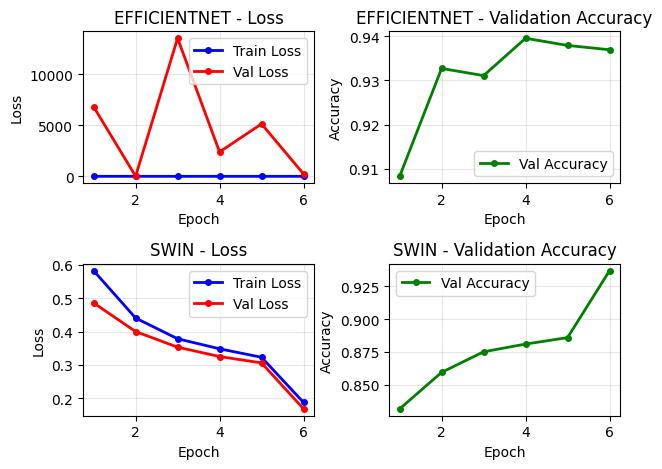


===== EPOCH 7/30 =====

Training efficientnet for Epoch 7...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 7 | Batch 50/913 | Loss 0.000011
Epoch 7 | Batch 100/913 | Loss 0.000575
Epoch 7 | Batch 150/913 | Loss 0.000000
Epoch 7 | Batch 200/913 | Loss 0.000009
Epoch 7 | Batch 250/913 | Loss 0.002179
Epoch 7 | Batch 300/913 | Loss 0.000000
Epoch 7 | Batch 350/913 | Loss 0.000140
Epoch 7 | Batch 400/913 | Loss 0.680031
Epoch 7 | Batch 450/913 | Loss 0.000000
Epoch 7 | Batch 500/913 | Loss 0.005161
Epoch 7 | Batch 550/913 | Loss 0.004371
Epoch 7 | Batch 600/913 | Loss 0.000001
Epoch 7 | Batch 650/913 | Loss 0.000000
Epoch 7 | Batch 700/913 | Loss 0.000049
Epoch 7 | Batch 750/913 | Loss 0.000000
Epoch 7 | Batch 800/913 | Loss 0.467297
Epoch 7 | Batch 850/913 | Loss 0.000012
Epoch 7 | Batch 900/913 | Loss 0.000472
Validating efficientnet for Epoch 7...
RESULTS: efficientnet | Epoch 7/30 | Train Loss: 0.057052 | Val Acc: 0.936281

Training swin for Epoch 7...
  Current 

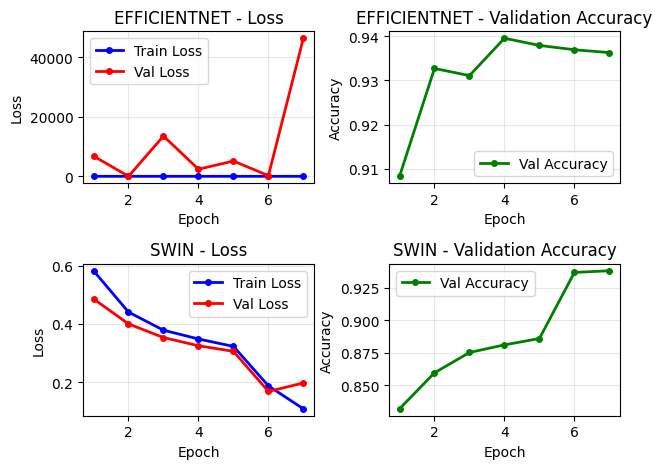


===== EPOCH 8/30 =====

Training efficientnet for Epoch 8...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 8 | Batch 50/913 | Loss 0.082919
Epoch 8 | Batch 100/913 | Loss 0.000118
Epoch 8 | Batch 150/913 | Loss 0.000000
Epoch 8 | Batch 200/913 | Loss 0.000001
Epoch 8 | Batch 250/913 | Loss 0.000064
Epoch 8 | Batch 300/913 | Loss 0.009806
Epoch 8 | Batch 350/913 | Loss 0.077084
Epoch 8 | Batch 400/913 | Loss 0.000000
Epoch 8 | Batch 450/913 | Loss 0.008727
Epoch 8 | Batch 500/913 | Loss 0.000025
Epoch 8 | Batch 550/913 | Loss 0.000004
Epoch 8 | Batch 600/913 | Loss 0.000000
Epoch 8 | Batch 650/913 | Loss 0.000000
Epoch 8 | Batch 700/913 | Loss 0.160649
Epoch 8 | Batch 750/913 | Loss 0.000000
Epoch 8 | Batch 800/913 | Loss 0.000000
Epoch 8 | Batch 850/913 | Loss 0.001726
Epoch 8 | Batch 900/913 | Loss 0.000039
Validating efficientnet for Epoch 8...
RESULTS: efficientnet | Epoch 8/30 | Train Loss: 0.043567 | Val Acc: 0.941808

Training swin for Epoch 8...
  Current 

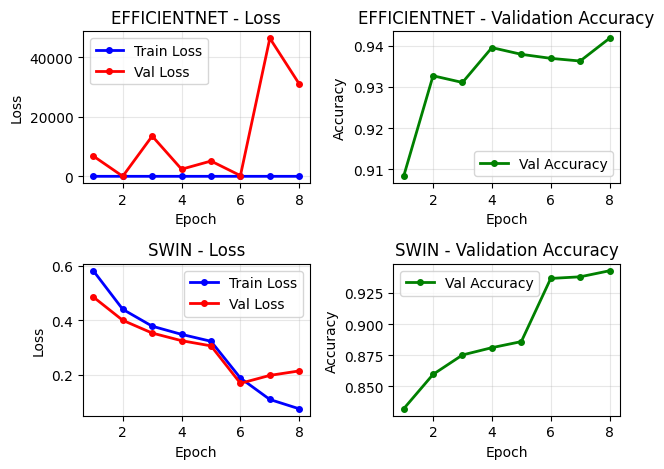


===== EPOCH 9/30 =====

Training efficientnet for Epoch 9...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 9 | Batch 50/913 | Loss 0.000000
Epoch 9 | Batch 100/913 | Loss 0.000000
Epoch 9 | Batch 150/913 | Loss 0.000016
Epoch 9 | Batch 200/913 | Loss 0.000403
Epoch 9 | Batch 250/913 | Loss 0.000000
Epoch 9 | Batch 300/913 | Loss 0.000253
Epoch 9 | Batch 350/913 | Loss 0.000063
Epoch 9 | Batch 400/913 | Loss 0.000040
Epoch 9 | Batch 450/913 | Loss 0.000011
Epoch 9 | Batch 500/913 | Loss 0.001061
Epoch 9 | Batch 550/913 | Loss 0.000000
Epoch 9 | Batch 600/913 | Loss 0.000000
Epoch 9 | Batch 650/913 | Loss 0.000395
Epoch 9 | Batch 700/913 | Loss 0.000165
Epoch 9 | Batch 750/913 | Loss 0.000000
Epoch 9 | Batch 800/913 | Loss 0.000001
Epoch 9 | Batch 850/913 | Loss 0.000001
Epoch 9 | Batch 900/913 | Loss 1.010870
Validating efficientnet for Epoch 9...
RESULTS: efficientnet | Epoch 9/30 | Train Loss: 0.035894 | Val Acc: 0.945059

Training swin for Epoch 9...
  Current 

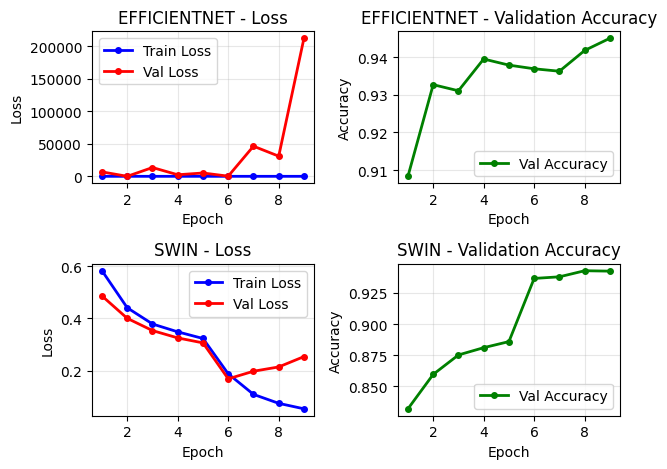


===== EPOCH 10/30 =====

Training efficientnet for Epoch 10...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 10 | Batch 50/913 | Loss 0.000000
Epoch 10 | Batch 100/913 | Loss 0.000000
Epoch 10 | Batch 150/913 | Loss 0.065216
Epoch 10 | Batch 200/913 | Loss 0.000000
Epoch 10 | Batch 250/913 | Loss 0.002010
Epoch 10 | Batch 300/913 | Loss 0.001856
Epoch 10 | Batch 350/913 | Loss 0.000048
Epoch 10 | Batch 400/913 | Loss 0.000000
Epoch 10 | Batch 450/913 | Loss 0.354647
Epoch 10 | Batch 500/913 | Loss 0.000000
Epoch 10 | Batch 550/913 | Loss 0.000010
Epoch 10 | Batch 600/913 | Loss 0.000063
Epoch 10 | Batch 650/913 | Loss 0.001278
Epoch 10 | Batch 700/913 | Loss 0.000000
Epoch 10 | Batch 750/913 | Loss 0.000000
Epoch 10 | Batch 800/913 | Loss 0.000000
Epoch 10 | Batch 850/913 | Loss 0.000003
Epoch 10 | Batch 900/913 | Loss 0.601293
Validating efficientnet for Epoch 10...
RESULTS: efficientnet | Epoch 10/30 | Train Loss: 0.024489 | Val Acc: 0.947659

Training swin for

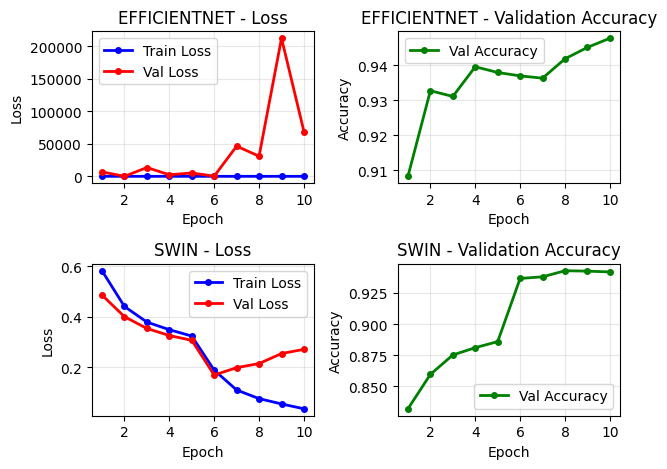


===== EPOCH 11/30 =====

Training efficientnet for Epoch 11...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 11 | Batch 50/913 | Loss 0.028161
Epoch 11 | Batch 100/913 | Loss 0.000038
Epoch 11 | Batch 150/913 | Loss 0.000000
Epoch 11 | Batch 200/913 | Loss 0.000000
Epoch 11 | Batch 250/913 | Loss 0.000012
Epoch 11 | Batch 300/913 | Loss 0.208231
Epoch 11 | Batch 350/913 | Loss 0.000000
Epoch 11 | Batch 400/913 | Loss 0.000000
Epoch 11 | Batch 450/913 | Loss 0.000000
Epoch 11 | Batch 500/913 | Loss 0.000000
Epoch 11 | Batch 550/913 | Loss 0.000000
Epoch 11 | Batch 600/913 | Loss 0.000001
Epoch 11 | Batch 650/913 | Loss 0.000000
Epoch 11 | Batch 700/913 | Loss 0.000000
Epoch 11 | Batch 750/913 | Loss 0.000012
Epoch 11 | Batch 800/913 | Loss 0.000000
Epoch 11 | Batch 850/913 | Loss 0.000001
Epoch 11 | Batch 900/913 | Loss 0.014987
Validating efficientnet for Epoch 11...
RESULTS: efficientnet | Epoch 11/30 | Train Loss: 0.025781 | Val Acc: 0.943433

Training swin for

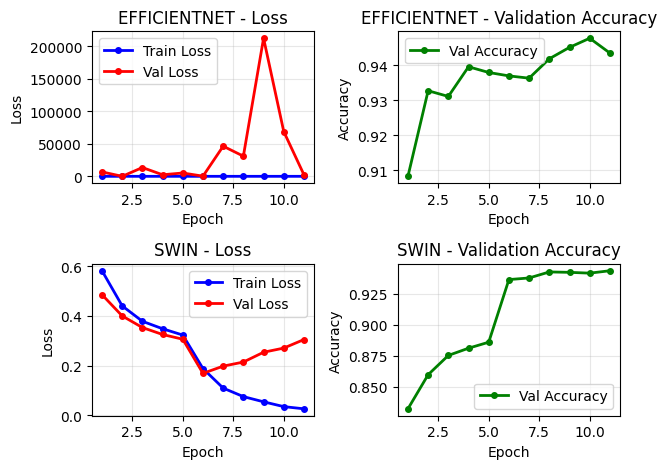


===== EPOCH 12/30 =====

Training efficientnet for Epoch 12...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 12 | Batch 50/913 | Loss 0.000030
Epoch 12 | Batch 100/913 | Loss 0.000000
Epoch 12 | Batch 150/913 | Loss 0.000000
Epoch 12 | Batch 200/913 | Loss 0.000000
Epoch 12 | Batch 250/913 | Loss 0.000000
Epoch 12 | Batch 300/913 | Loss 0.000562
Epoch 12 | Batch 350/913 | Loss 0.005115
Epoch 12 | Batch 400/913 | Loss 0.000000
Epoch 12 | Batch 450/913 | Loss 0.000002
Epoch 12 | Batch 500/913 | Loss 0.065769
Epoch 12 | Batch 550/913 | Loss 0.000000
Epoch 12 | Batch 600/913 | Loss 0.000306
Epoch 12 | Batch 650/913 | Loss 0.000632
Epoch 12 | Batch 700/913 | Loss 0.000171
Epoch 12 | Batch 750/913 | Loss 0.000000
Epoch 12 | Batch 800/913 | Loss 0.002464
Epoch 12 | Batch 850/913 | Loss 0.001630
Epoch 12 | Batch 900/913 | Loss 0.000001
Validating efficientnet for Epoch 12...
RESULTS: efficientnet | Epoch 12/30 | Train Loss: 0.018766 | Val Acc: 0.938231

Training swin for

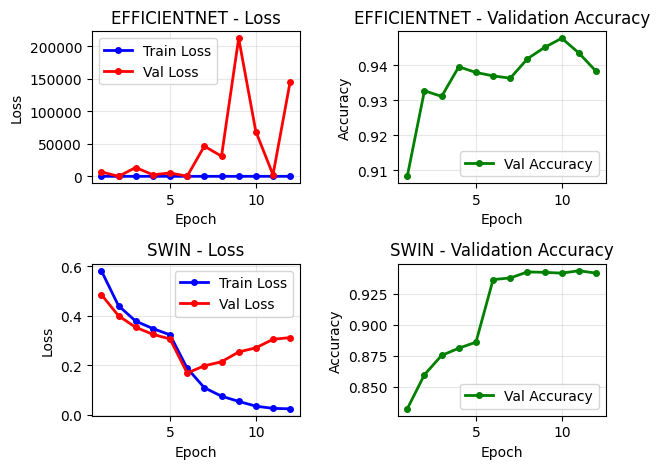


===== EPOCH 13/30 =====

Training efficientnet for Epoch 13...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 13 | Batch 50/913 | Loss 0.000007
Epoch 13 | Batch 100/913 | Loss 0.000000
Epoch 13 | Batch 150/913 | Loss 0.000010
Epoch 13 | Batch 200/913 | Loss 0.000000
Epoch 13 | Batch 250/913 | Loss 0.000003
Epoch 13 | Batch 300/913 | Loss 0.000002
Epoch 13 | Batch 350/913 | Loss 0.000000
Epoch 13 | Batch 400/913 | Loss 0.000010
Epoch 13 | Batch 450/913 | Loss 0.000000
Epoch 13 | Batch 500/913 | Loss 0.000000
Epoch 13 | Batch 550/913 | Loss 0.000000
Epoch 13 | Batch 600/913 | Loss 0.000000
Epoch 13 | Batch 650/913 | Loss 0.000230
Epoch 13 | Batch 700/913 | Loss 0.000000
Epoch 13 | Batch 750/913 | Loss 0.000000
Epoch 13 | Batch 800/913 | Loss 0.006155
Epoch 13 | Batch 850/913 | Loss 0.419519
Epoch 13 | Batch 900/913 | Loss 0.000000
Validating efficientnet for Epoch 13...
RESULTS: efficientnet | Epoch 13/30 | Train Loss: 0.024449 | Val Acc: 0.940507

Training swin for

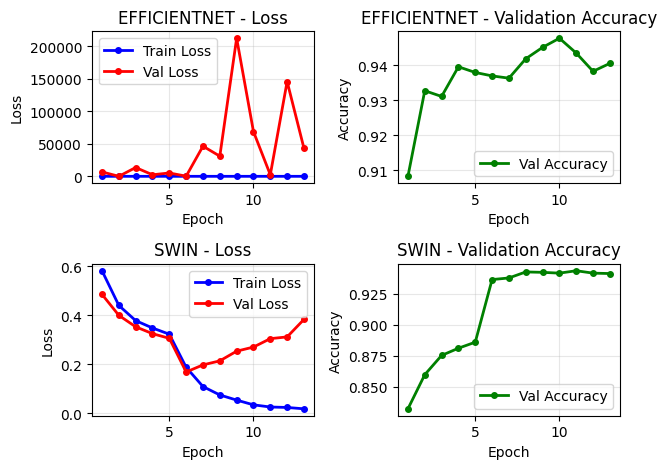


===== EPOCH 14/30 =====

Training efficientnet for Epoch 14...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 14 | Batch 50/913 | Loss 0.000000
Epoch 14 | Batch 100/913 | Loss 0.000780
Epoch 14 | Batch 150/913 | Loss 0.000000
Epoch 14 | Batch 200/913 | Loss 0.000274
Epoch 14 | Batch 250/913 | Loss 0.000000
Epoch 14 | Batch 300/913 | Loss 0.000000
Epoch 14 | Batch 350/913 | Loss 0.000000
Epoch 14 | Batch 400/913 | Loss 0.000000
Epoch 14 | Batch 450/913 | Loss 0.000000
Epoch 14 | Batch 500/913 | Loss 0.000000
Epoch 14 | Batch 550/913 | Loss 0.000025
Epoch 14 | Batch 600/913 | Loss 0.000000
Epoch 14 | Batch 650/913 | Loss 0.000000
Epoch 14 | Batch 700/913 | Loss 0.000000
Epoch 14 | Batch 750/913 | Loss 0.000075
Epoch 14 | Batch 800/913 | Loss 0.000000
Epoch 14 | Batch 850/913 | Loss 0.000000
Epoch 14 | Batch 900/913 | Loss 0.001012
Validating efficientnet for Epoch 14...
RESULTS: efficientnet | Epoch 14/30 | Train Loss: 0.023147 | Val Acc: 0.942458

Training swin for

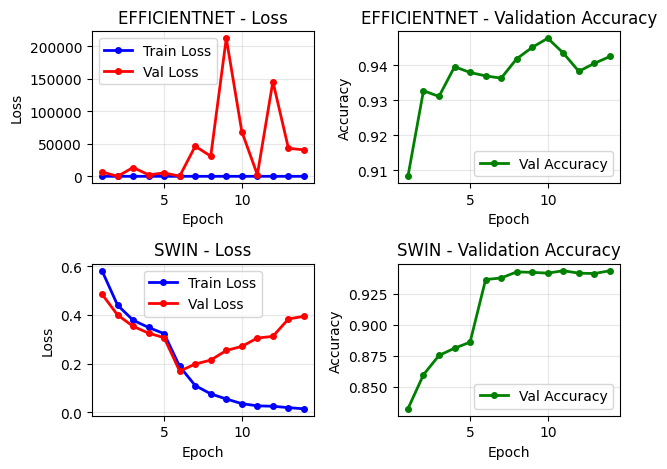


===== EPOCH 15/30 =====

Training efficientnet for Epoch 15...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 15 | Batch 50/913 | Loss 0.000000
Epoch 15 | Batch 100/913 | Loss 0.000000
Epoch 15 | Batch 150/913 | Loss 0.000000
Epoch 15 | Batch 200/913 | Loss 0.000000
Epoch 15 | Batch 250/913 | Loss 0.127708
Epoch 15 | Batch 300/913 | Loss 0.000000
Epoch 15 | Batch 350/913 | Loss 0.000000
Epoch 15 | Batch 400/913 | Loss 0.000000
Epoch 15 | Batch 450/913 | Loss 0.000067
Epoch 15 | Batch 500/913 | Loss 0.000000
Epoch 15 | Batch 550/913 | Loss 0.000000
Epoch 15 | Batch 600/913 | Loss 0.000000
Epoch 15 | Batch 650/913 | Loss 0.000473
Epoch 15 | Batch 700/913 | Loss 0.000000
Epoch 15 | Batch 750/913 | Loss 0.000000
Epoch 15 | Batch 800/913 | Loss 0.000000
Epoch 15 | Batch 850/913 | Loss 0.000000
Epoch 15 | Batch 900/913 | Loss 0.000000
Validating efficientnet for Epoch 15...
RESULTS: efficientnet | Epoch 15/30 | Train Loss: 0.023592 | Val Acc: 0.949610

Training swin for

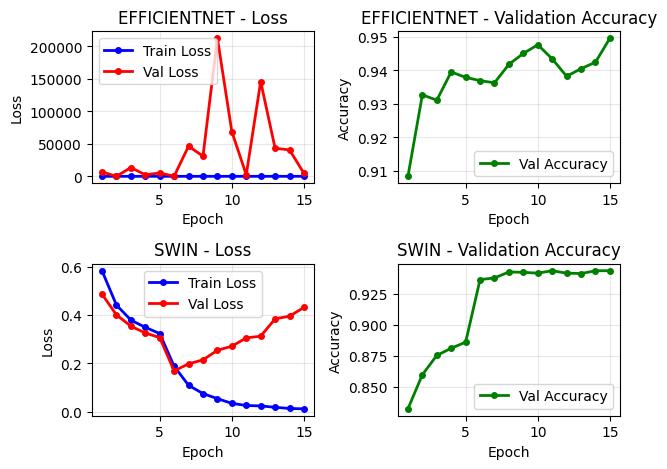


===== EPOCH 16/30 =====

Training efficientnet for Epoch 16...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 16 | Batch 50/913 | Loss 0.000000
Epoch 16 | Batch 100/913 | Loss 0.000000
Epoch 16 | Batch 150/913 | Loss 0.159061
Epoch 16 | Batch 200/913 | Loss 0.000002
Epoch 16 | Batch 250/913 | Loss 0.000001
Epoch 16 | Batch 300/913 | Loss 0.000000
Epoch 16 | Batch 350/913 | Loss 0.000000
Epoch 16 | Batch 400/913 | Loss 0.000000
Epoch 16 | Batch 450/913 | Loss 0.000000
Epoch 16 | Batch 500/913 | Loss 0.002522
Epoch 16 | Batch 550/913 | Loss 0.000000
Epoch 16 | Batch 600/913 | Loss 0.000001
Epoch 16 | Batch 650/913 | Loss 0.000001
Epoch 16 | Batch 700/913 | Loss 0.000000
Epoch 16 | Batch 750/913 | Loss 0.000000
Epoch 16 | Batch 800/913 | Loss 0.000000
Epoch 16 | Batch 850/913 | Loss 0.004014
Epoch 16 | Batch 900/913 | Loss 0.128869
Validating efficientnet for Epoch 16...
RESULTS: efficientnet | Epoch 16/30 | Train Loss: 0.017462 | Val Acc: 0.938882

Training swin for

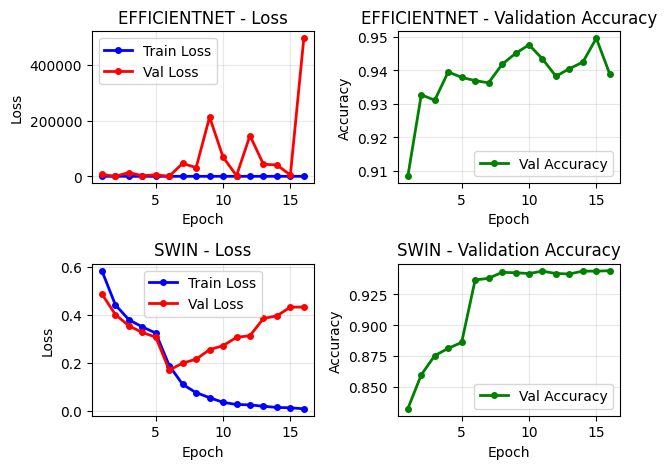


===== EPOCH 17/30 =====

Training efficientnet for Epoch 17...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 17 | Batch 50/913 | Loss 0.000001
Epoch 17 | Batch 100/913 | Loss 0.000000
Epoch 17 | Batch 150/913 | Loss 0.000000
Epoch 17 | Batch 200/913 | Loss 0.000000
Epoch 17 | Batch 250/913 | Loss 0.000286
Epoch 17 | Batch 300/913 | Loss 0.000000
Epoch 17 | Batch 350/913 | Loss 0.002002
Epoch 17 | Batch 400/913 | Loss 0.000000
Epoch 17 | Batch 450/913 | Loss 0.000000
Epoch 17 | Batch 500/913 | Loss 2.517139
Epoch 17 | Batch 550/913 | Loss 0.000000
Epoch 17 | Batch 600/913 | Loss 0.459285
Epoch 17 | Batch 650/913 | Loss 0.000000
Epoch 17 | Batch 700/913 | Loss 0.000001
Epoch 17 | Batch 750/913 | Loss 0.000000
Epoch 17 | Batch 800/913 | Loss 0.000000
Epoch 17 | Batch 850/913 | Loss 0.000000
Epoch 17 | Batch 900/913 | Loss 0.104037
Validating efficientnet for Epoch 17...
RESULTS: efficientnet | Epoch 17/30 | Train Loss: 0.025518 | Val Acc: 0.948960

Training swin for

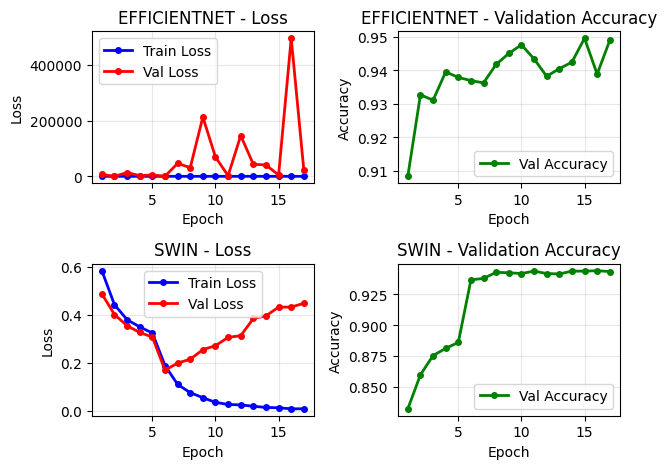


===== EPOCH 18/30 =====

Training efficientnet for Epoch 18...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 18 | Batch 50/913 | Loss 0.000002
Epoch 18 | Batch 100/913 | Loss 0.000000
Epoch 18 | Batch 150/913 | Loss 0.000000
Epoch 18 | Batch 200/913 | Loss 0.000000
Epoch 18 | Batch 250/913 | Loss 0.000000
Epoch 18 | Batch 300/913 | Loss 0.000000
Epoch 18 | Batch 350/913 | Loss 0.000000
Epoch 18 | Batch 400/913 | Loss 0.000000
Epoch 18 | Batch 450/913 | Loss 0.000000
Epoch 18 | Batch 500/913 | Loss 0.000000
Epoch 18 | Batch 550/913 | Loss 0.000006
Epoch 18 | Batch 600/913 | Loss 0.000000
Epoch 18 | Batch 650/913 | Loss 0.000000
Epoch 18 | Batch 700/913 | Loss 0.000000
Epoch 18 | Batch 750/913 | Loss 0.000000
Epoch 18 | Batch 800/913 | Loss 0.000000
Epoch 18 | Batch 850/913 | Loss 0.000000
Epoch 18 | Batch 900/913 | Loss 0.014011
Validating efficientnet for Epoch 18...
RESULTS: efficientnet | Epoch 18/30 | Train Loss: 0.021815 | Val Acc: 0.946359

Training swin for

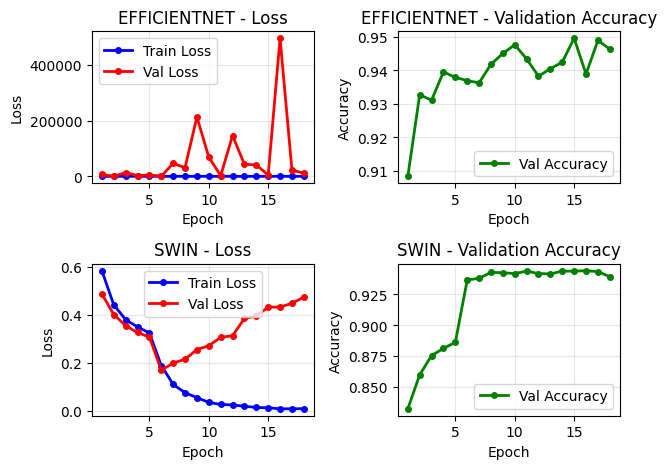


===== EPOCH 19/30 =====

Training efficientnet for Epoch 19...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 19 | Batch 50/913 | Loss 0.000000
Epoch 19 | Batch 100/913 | Loss 0.000001
Epoch 19 | Batch 150/913 | Loss 0.000000
Epoch 19 | Batch 200/913 | Loss 0.000000
Epoch 19 | Batch 250/913 | Loss 0.000000
Epoch 19 | Batch 300/913 | Loss 0.000000
Epoch 19 | Batch 350/913 | Loss 0.000000
Epoch 19 | Batch 400/913 | Loss 0.000000
Epoch 19 | Batch 450/913 | Loss 0.000000
Epoch 19 | Batch 500/913 | Loss 0.000465
Epoch 19 | Batch 550/913 | Loss 0.000000
Epoch 19 | Batch 600/913 | Loss 0.000000
Epoch 19 | Batch 650/913 | Loss 0.036519
Epoch 19 | Batch 700/913 | Loss 0.031632
Epoch 19 | Batch 750/913 | Loss 0.000000
Epoch 19 | Batch 800/913 | Loss 0.000000
Epoch 19 | Batch 850/913 | Loss 0.000000
Epoch 19 | Batch 900/913 | Loss 0.000086
Validating efficientnet for Epoch 19...
RESULTS: efficientnet | Epoch 19/30 | Train Loss: 0.012517 | Val Acc: 0.946034

Training swin for

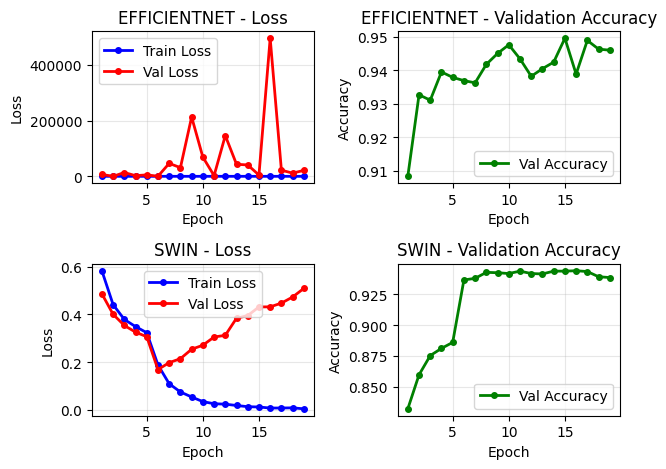


===== EPOCH 20/30 =====

Training efficientnet for Epoch 20...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 20 | Batch 50/913 | Loss 0.000000
Epoch 20 | Batch 100/913 | Loss 0.000006
Epoch 20 | Batch 150/913 | Loss 0.000000
Epoch 20 | Batch 200/913 | Loss 0.001337
Epoch 20 | Batch 250/913 | Loss 0.000000
Epoch 20 | Batch 300/913 | Loss 0.000000
Epoch 20 | Batch 350/913 | Loss 0.000000
Epoch 20 | Batch 400/913 | Loss 0.000000
Epoch 20 | Batch 450/913 | Loss 0.000000
Epoch 20 | Batch 500/913 | Loss 0.000000
Epoch 20 | Batch 550/913 | Loss 0.000000
Epoch 20 | Batch 600/913 | Loss 0.000000
Epoch 20 | Batch 650/913 | Loss 0.000000
Epoch 20 | Batch 700/913 | Loss 0.000001
Epoch 20 | Batch 750/913 | Loss 0.000000
Epoch 20 | Batch 800/913 | Loss 0.000000
Epoch 20 | Batch 850/913 | Loss 0.000000
Epoch 20 | Batch 900/913 | Loss 0.000000
Validating efficientnet for Epoch 20...
RESULTS: efficientnet | Epoch 20/30 | Train Loss: 0.019508 | Val Acc: 0.946684

Training swin for

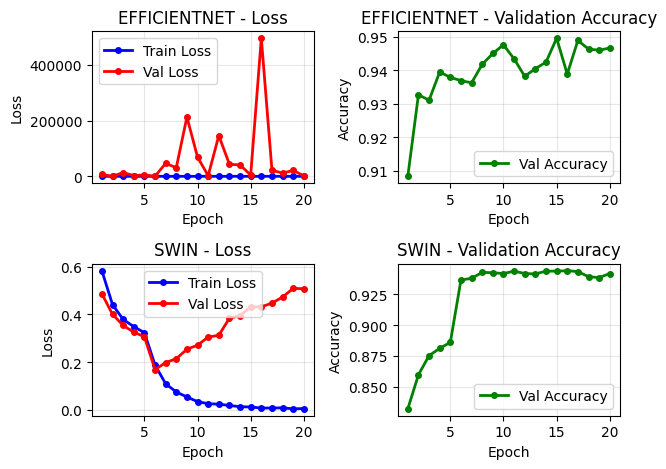


===== EPOCH 21/30 =====

Training efficientnet for Epoch 21...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 21 | Batch 50/913 | Loss 0.107978
Epoch 21 | Batch 100/913 | Loss 0.000000
Epoch 21 | Batch 150/913 | Loss 0.000023
Epoch 21 | Batch 200/913 | Loss 0.000000
Epoch 21 | Batch 250/913 | Loss 0.000000
Epoch 21 | Batch 300/913 | Loss 0.000000
Epoch 21 | Batch 350/913 | Loss 0.000000
Epoch 21 | Batch 400/913 | Loss 0.000000
Epoch 21 | Batch 450/913 | Loss 0.000000
Epoch 21 | Batch 500/913 | Loss 0.000007
Epoch 21 | Batch 550/913 | Loss 0.000000
Epoch 21 | Batch 600/913 | Loss 0.000017
Epoch 21 | Batch 650/913 | Loss 0.000000
Epoch 21 | Batch 700/913 | Loss 0.000044
Epoch 21 | Batch 750/913 | Loss 0.000179
Epoch 21 | Batch 800/913 | Loss 0.000000
Epoch 21 | Batch 850/913 | Loss 0.000000
Epoch 21 | Batch 900/913 | Loss 0.000001
Validating efficientnet for Epoch 21...
RESULTS: efficientnet | Epoch 21/30 | Train Loss: 0.009778 | Val Acc: 0.944408

Training swin for

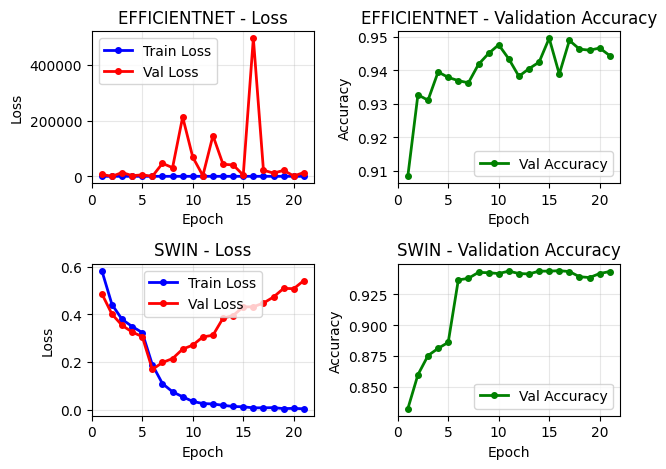


===== EPOCH 22/30 =====

Training efficientnet for Epoch 22...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 22 | Batch 50/913 | Loss 0.000000
Epoch 22 | Batch 100/913 | Loss 0.000000
Epoch 22 | Batch 150/913 | Loss 0.000000
Epoch 22 | Batch 200/913 | Loss 0.000000
Epoch 22 | Batch 250/913 | Loss 0.000000
Epoch 22 | Batch 300/913 | Loss 0.000000
Epoch 22 | Batch 350/913 | Loss 0.000000
Epoch 22 | Batch 400/913 | Loss 0.000000
Epoch 22 | Batch 450/913 | Loss 0.000000
Epoch 22 | Batch 500/913 | Loss 0.000000
Epoch 22 | Batch 550/913 | Loss 0.000000
Epoch 22 | Batch 600/913 | Loss 0.000000
Epoch 22 | Batch 650/913 | Loss 0.000000
Epoch 22 | Batch 700/913 | Loss 0.000000
Epoch 22 | Batch 750/913 | Loss 0.003050
Epoch 22 | Batch 800/913 | Loss 0.000000
Epoch 22 | Batch 850/913 | Loss 0.000000
Epoch 22 | Batch 900/913 | Loss 0.043902
Validating efficientnet for Epoch 22...
RESULTS: efficientnet | Epoch 22/30 | Train Loss: 0.014304 | Val Acc: 0.945059

Training swin for

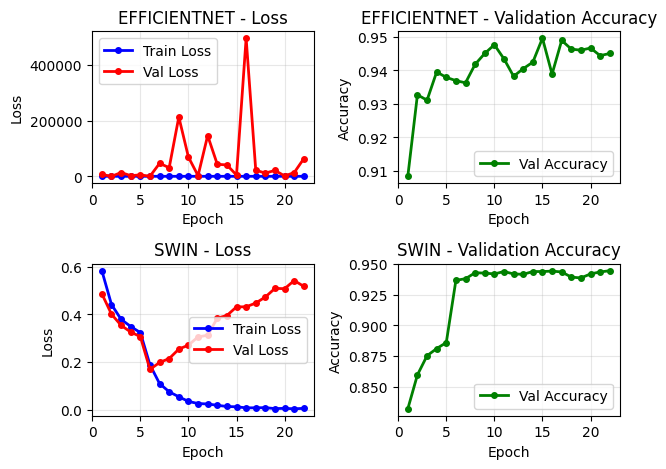


===== EPOCH 23/30 =====

Training efficientnet for Epoch 23...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 23 | Batch 50/913 | Loss 0.000000
Epoch 23 | Batch 100/913 | Loss 0.000000
Epoch 23 | Batch 150/913 | Loss 0.363242
Epoch 23 | Batch 200/913 | Loss 0.000000
Epoch 23 | Batch 250/913 | Loss 0.000000
Epoch 23 | Batch 300/913 | Loss 0.000000
Epoch 23 | Batch 350/913 | Loss 0.076636
Epoch 23 | Batch 400/913 | Loss 0.000000
Epoch 23 | Batch 450/913 | Loss 0.000000
Epoch 23 | Batch 500/913 | Loss 0.000002
Epoch 23 | Batch 550/913 | Loss 0.000000
Epoch 23 | Batch 600/913 | Loss 0.000000
Epoch 23 | Batch 650/913 | Loss 0.000000
Epoch 23 | Batch 700/913 | Loss 0.000014
Epoch 23 | Batch 750/913 | Loss 0.000000
Epoch 23 | Batch 800/913 | Loss 0.000000
Epoch 23 | Batch 850/913 | Loss 0.000000
Epoch 23 | Batch 900/913 | Loss 0.002746
Validating efficientnet for Epoch 23...
RESULTS: efficientnet | Epoch 23/30 | Train Loss: 0.007758 | Val Acc: 0.952211

Training swin for

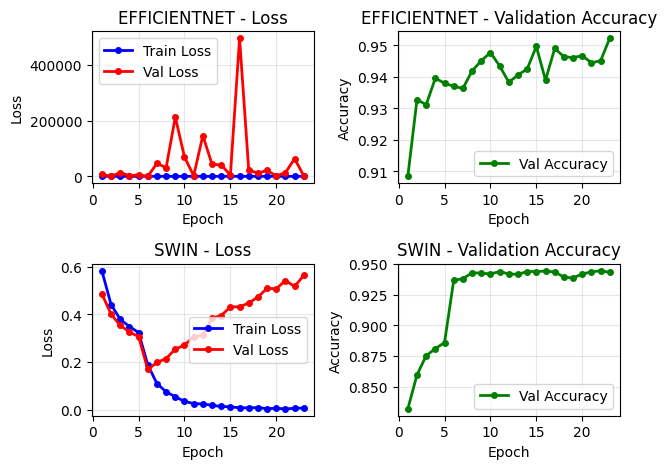


===== EPOCH 24/30 =====

Training efficientnet for Epoch 24...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 24 | Batch 50/913 | Loss 0.000000
Epoch 24 | Batch 100/913 | Loss 0.000000
Epoch 24 | Batch 150/913 | Loss 0.000000
Epoch 24 | Batch 200/913 | Loss 0.000000
Epoch 24 | Batch 250/913 | Loss 0.000000
Epoch 24 | Batch 300/913 | Loss 0.000000
Epoch 24 | Batch 350/913 | Loss 0.000000
Epoch 24 | Batch 400/913 | Loss 0.000000
Epoch 24 | Batch 450/913 | Loss 0.000008
Epoch 24 | Batch 500/913 | Loss 0.000000
Epoch 24 | Batch 550/913 | Loss 0.000000
Epoch 24 | Batch 600/913 | Loss 0.000000
Epoch 24 | Batch 650/913 | Loss 0.000000
Epoch 24 | Batch 700/913 | Loss 0.000000
Epoch 24 | Batch 750/913 | Loss 0.000000
Epoch 24 | Batch 800/913 | Loss 0.000000
Epoch 24 | Batch 850/913 | Loss 0.000002
Epoch 24 | Batch 900/913 | Loss 0.000000
Validating efficientnet for Epoch 24...
RESULTS: efficientnet | Epoch 24/30 | Train Loss: 0.012319 | Val Acc: 0.945709

Training swin for

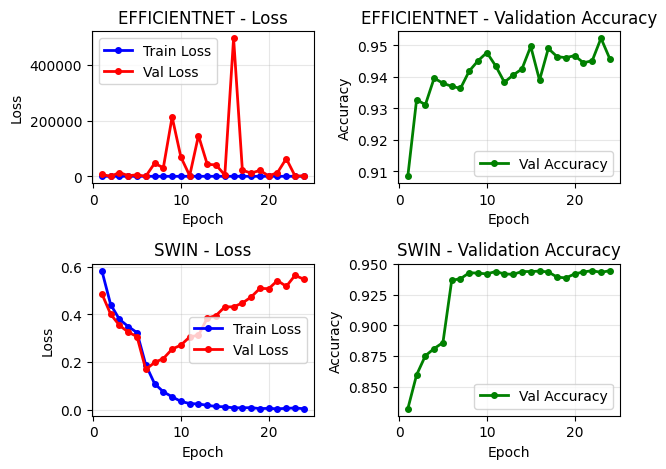


===== EPOCH 25/30 =====

Training efficientnet for Epoch 25...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 25 | Batch 50/913 | Loss 0.000000
Epoch 25 | Batch 100/913 | Loss 0.000003
Epoch 25 | Batch 150/913 | Loss 0.000000
Epoch 25 | Batch 200/913 | Loss 0.000000
Epoch 25 | Batch 250/913 | Loss 0.434600
Epoch 25 | Batch 300/913 | Loss 0.000000
Epoch 25 | Batch 350/913 | Loss 0.144485
Epoch 25 | Batch 400/913 | Loss 0.000000
Epoch 25 | Batch 450/913 | Loss 0.000000
Epoch 25 | Batch 500/913 | Loss 0.000000
Epoch 25 | Batch 550/913 | Loss 0.000000
Epoch 25 | Batch 600/913 | Loss 0.000000
Epoch 25 | Batch 650/913 | Loss 0.000001
Epoch 25 | Batch 700/913 | Loss 0.000000
Epoch 25 | Batch 750/913 | Loss 0.000000
Epoch 25 | Batch 800/913 | Loss 0.000000
Epoch 25 | Batch 850/913 | Loss 0.000000
Epoch 25 | Batch 900/913 | Loss 0.112440
Validating efficientnet for Epoch 25...
RESULTS: efficientnet | Epoch 25/30 | Train Loss: 0.021300 | Val Acc: 0.946359

Training swin for

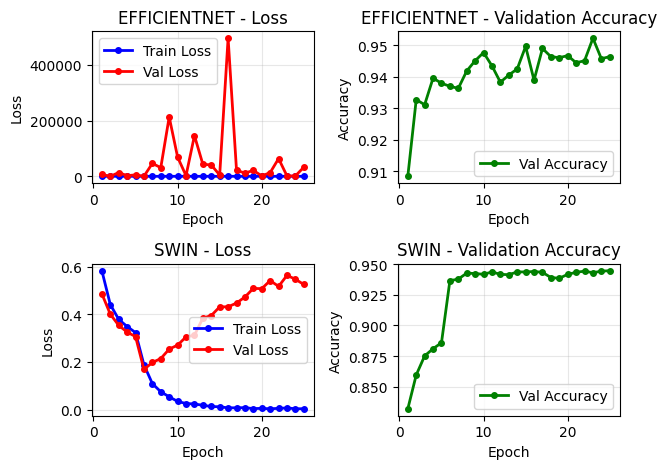


===== EPOCH 26/30 =====

Training efficientnet for Epoch 26...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 26 | Batch 50/913 | Loss 0.681439
Epoch 26 | Batch 100/913 | Loss 0.000000
Epoch 26 | Batch 150/913 | Loss 0.000000
Epoch 26 | Batch 200/913 | Loss 0.000000
Epoch 26 | Batch 250/913 | Loss 0.000000
Epoch 26 | Batch 300/913 | Loss 0.000000
Epoch 26 | Batch 350/913 | Loss 0.000000
Epoch 26 | Batch 400/913 | Loss 0.000009
Epoch 26 | Batch 450/913 | Loss 0.000000
Epoch 26 | Batch 500/913 | Loss 0.000000
Epoch 26 | Batch 550/913 | Loss 0.000000
Epoch 26 | Batch 600/913 | Loss 0.000000
Epoch 26 | Batch 650/913 | Loss 0.000000
Epoch 26 | Batch 700/913 | Loss 0.000000
Epoch 26 | Batch 750/913 | Loss 0.000000
Epoch 26 | Batch 800/913 | Loss 0.000058
Epoch 26 | Batch 850/913 | Loss 0.000000
Epoch 26 | Batch 900/913 | Loss 0.009106
Validating efficientnet for Epoch 26...
RESULTS: efficientnet | Epoch 26/30 | Train Loss: 0.011340 | Val Acc: 0.953186

Training swin for

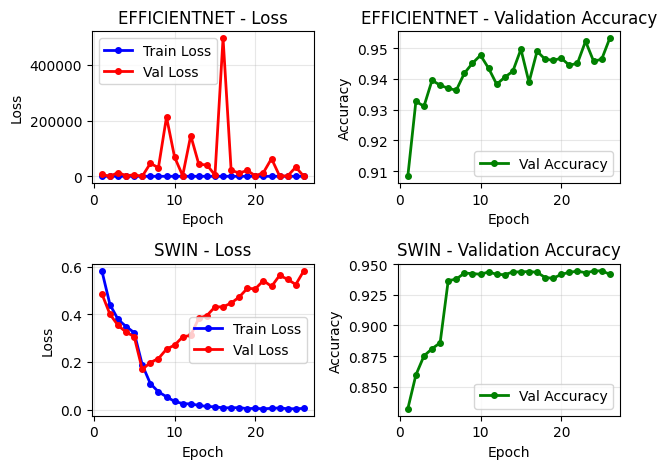


===== EPOCH 27/30 =====

Training efficientnet for Epoch 27...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 27 | Batch 50/913 | Loss 0.000000
Epoch 27 | Batch 100/913 | Loss 0.000000
Epoch 27 | Batch 150/913 | Loss 0.000000
Epoch 27 | Batch 200/913 | Loss 0.000000
Epoch 27 | Batch 250/913 | Loss 0.000000
Epoch 27 | Batch 300/913 | Loss 0.000000
Epoch 27 | Batch 350/913 | Loss 0.000000
Epoch 27 | Batch 400/913 | Loss 0.000001
Epoch 27 | Batch 450/913 | Loss 0.000000
Epoch 27 | Batch 500/913 | Loss 0.000002
Epoch 27 | Batch 550/913 | Loss 0.000000
Epoch 27 | Batch 600/913 | Loss 0.000000
Epoch 27 | Batch 650/913 | Loss 0.000000
Epoch 27 | Batch 700/913 | Loss 0.000000
Epoch 27 | Batch 750/913 | Loss 0.000000
Epoch 27 | Batch 800/913 | Loss 0.000000
Epoch 27 | Batch 850/913 | Loss 0.000000
Epoch 27 | Batch 900/913 | Loss 0.000000
Validating efficientnet for Epoch 27...
RESULTS: efficientnet | Epoch 27/30 | Train Loss: 0.013619 | Val Acc: 0.948309

Training swin for

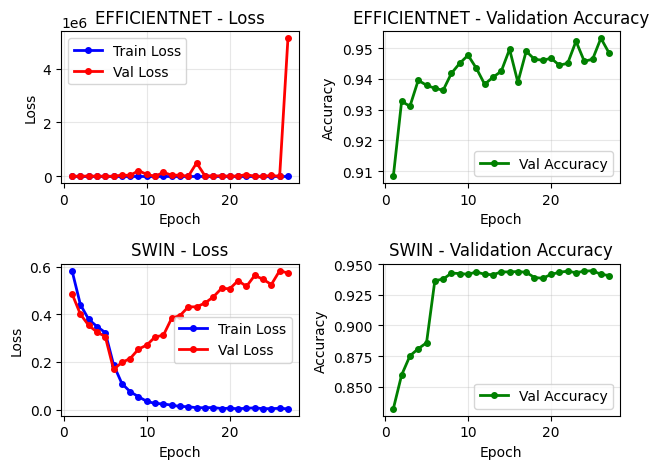


===== EPOCH 28/30 =====

Training efficientnet for Epoch 28...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 28 | Batch 50/913 | Loss 0.000001
Epoch 28 | Batch 100/913 | Loss 0.000000
Epoch 28 | Batch 150/913 | Loss 0.000000
Epoch 28 | Batch 200/913 | Loss 0.000000
Epoch 28 | Batch 250/913 | Loss 0.000000
Epoch 28 | Batch 300/913 | Loss 0.254689
Epoch 28 | Batch 350/913 | Loss 0.000000
Epoch 28 | Batch 400/913 | Loss 0.000000
Epoch 28 | Batch 450/913 | Loss 0.000000
Epoch 28 | Batch 500/913 | Loss 0.064509
Epoch 28 | Batch 550/913 | Loss 0.000000
Epoch 28 | Batch 600/913 | Loss 0.000000
Epoch 28 | Batch 650/913 | Loss 0.000000
Epoch 28 | Batch 700/913 | Loss 0.000000
Epoch 28 | Batch 750/913 | Loss 0.000000
Epoch 28 | Batch 800/913 | Loss 0.000000
Epoch 28 | Batch 850/913 | Loss 0.210363
Epoch 28 | Batch 900/913 | Loss 0.608263
Validating efficientnet for Epoch 28...
RESULTS: efficientnet | Epoch 28/30 | Train Loss: 0.013990 | Val Acc: 0.953836

Training swin for

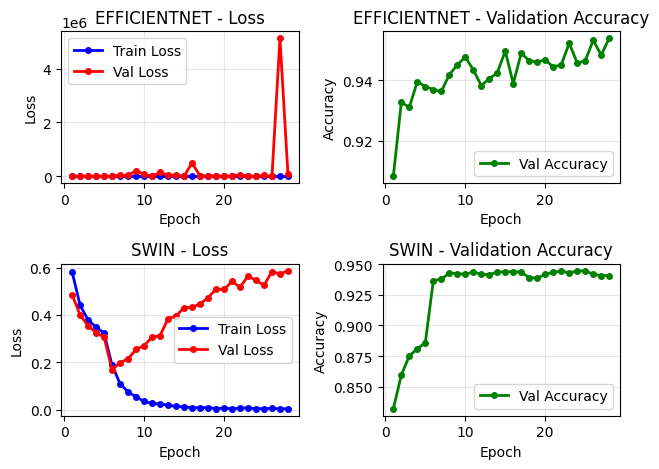


===== EPOCH 29/30 =====

Training efficientnet for Epoch 29...
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-05
Epoch 29 | Batch 50/913 | Loss 0.000000
Epoch 29 | Batch 100/913 | Loss 0.000000
Epoch 29 | Batch 150/913 | Loss 0.000000
Epoch 29 | Batch 200/913 | Loss 0.000000
Epoch 29 | Batch 250/913 | Loss 0.000003
Epoch 29 | Batch 300/913 | Loss 0.000000
Epoch 29 | Batch 350/913 | Loss 0.000000
Epoch 29 | Batch 400/913 | Loss 0.000000
Epoch 29 | Batch 450/913 | Loss 0.001923
Epoch 29 | Batch 500/913 | Loss 0.000000
Epoch 29 | Batch 550/913 | Loss 0.000000
Epoch 29 | Batch 600/913 | Loss 0.000000
Epoch 29 | Batch 650/913 | Loss 0.000000
Epoch 29 | Batch 700/913 | Loss 0.016522
Epoch 29 | Batch 750/913 | Loss 0.000000
Epoch 29 | Batch 800/913 | Loss 0.001157
Epoch 29 | Batch 850/913 | Loss 0.000000
Epoch 29 | Batch 900/913 | Loss 0.000000
Validating efficientnet for Epoch 29...
RESULTS: efficientnet | Epoch 29/30 | Train Loss: 0.011043 | Val Acc: 0.955462

Training swin for

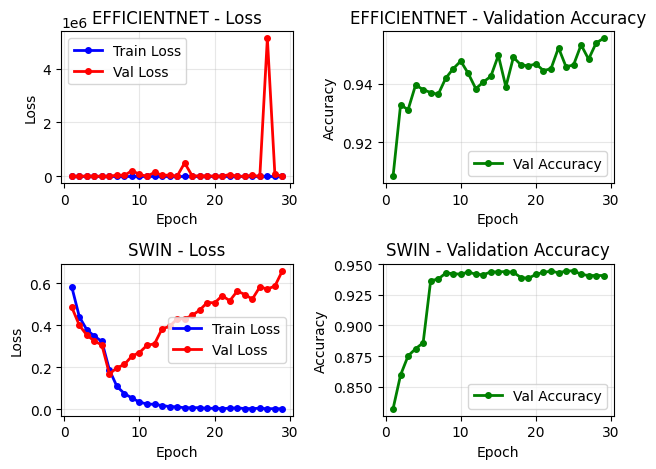


===== EPOCH 30/30 =====

Training efficientnet for Epoch 30...
  Current LRs for efficientnet:
    Group 'group_0': 5.00e-06
Epoch 30 | Batch 50/913 | Loss 0.000000
Epoch 30 | Batch 100/913 | Loss 0.000000
Epoch 30 | Batch 150/913 | Loss 0.000000
Epoch 30 | Batch 200/913 | Loss 0.000000
Epoch 30 | Batch 250/913 | Loss 0.000000
Epoch 30 | Batch 300/913 | Loss 0.000000
Epoch 30 | Batch 350/913 | Loss 0.000000
Epoch 30 | Batch 400/913 | Loss 0.000000
Epoch 30 | Batch 450/913 | Loss 0.000000
Epoch 30 | Batch 500/913 | Loss 0.000000
Epoch 30 | Batch 550/913 | Loss 0.000001
Epoch 30 | Batch 600/913 | Loss 0.000000
Epoch 30 | Batch 650/913 | Loss 0.000000
Epoch 30 | Batch 700/913 | Loss 0.000000
Epoch 30 | Batch 750/913 | Loss 0.000000
Epoch 30 | Batch 800/913 | Loss 0.000000
Epoch 30 | Batch 850/913 | Loss 0.000000
Epoch 30 | Batch 900/913 | Loss 0.133209
Validating efficientnet for Epoch 30...
RESULTS: efficientnet | Epoch 30/30 | Train Loss: 0.008828 | Val Acc: 0.954486

Training swin for

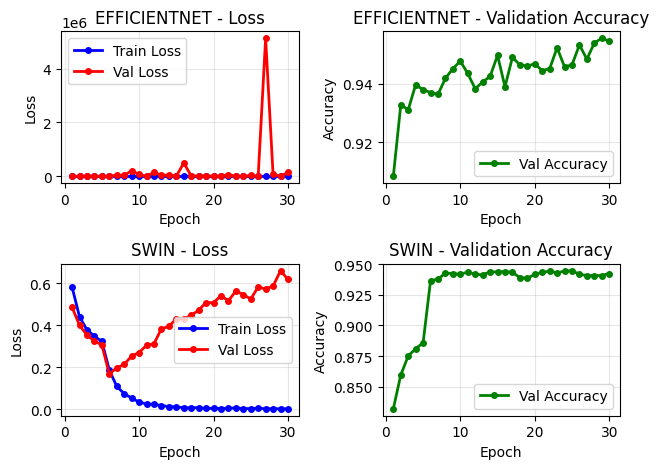


--- Saving Training Results ---
Detailed results saved to /kaggle/working/Training Data/efficientnet_results_2025-09-15_02-27-58_run1.json
Detailed results saved to /kaggle/working/Training Data/swin_results_2025-09-15_02-27-58_run1.json

--- Training complete. Results saved. ---


In [9]:
# import torch
# from timm.scheduler import CosineLRScheduler
# from datetime import datetime
# import os
# import json
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
import torch.optim # For torch.optim.lr_scheduler.ReduceLROnPlateau

def eval_dataset_with_loss(model, loader, loss_fn):
    model.eval()
    group_logits = defaultdict(list)
    group_labels = {}
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for x, y, pid in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            
            # Calculate loss for this batch
            batch_loss = loss_fn(logits, y)
            total_loss += batch_loss.item() * x.size(0)
            total_samples += x.size(0)
            
            # Continue with painting-level aggregation
            logits_cpu = logits.cpu()
            for lg, yy, id_ in zip(logits_cpu, y.cpu(), pid):
                group_logits[id_].append(lg)
                group_labels[id_] = int(yy)

    # Calculate average loss
    avg_loss = total_loss / total_samples

    # Class balance print
    y_true = list(group_labels.values())

    # Compute painting-level accuracy
    y_pred = [int(torch.stack(lgs).mean(0).argmax()) for lgs in group_logits.values()]
    acc = sum(yt==yp for yt, yp in zip(y_true, y_pred)) / len(y_true)
    
    return acc, avg_loss

# --- ASSUMPTIONS ---
# - 'models': dictionary containing your initialized models, including models['swin']
# - 'optimizers': dictionary with optimizers. optimizers['swin'] MUST have been
#   configured with two parameter groups:
#   {'params': backbone_params, 'lr': SWIN_LR_BACKBONE_FROZEN, 'name': 'swin_backbone'}
#   {'params': head_params, 'lr': SWIN_LR_HEAD_FROZEN, 'name': 'swin_head'}
#   and backbone params initially set to requires_grad=False.
# - 'device': torch.device configured (e.g., "mps", "cuda", "cpu")
# - 'train_loader', 'val_loader': DataLoader instances
# - 'loss_fn': Your loss function (e.g., CrossEntropyLoss)
# - 'train_one_epoch': Function to train for one epoch
# - 'eval_dataset': Function to evaluate on the validation set.
# - 'save_training_results': Function to save metrics.

# --- Configuration ---
EPOCHS = 30  # Total number of epochs to train
# N_FREEZE_EPOCHS_SWIN: Unfreeze Swin backbone *before* starting this epoch (0-indexed).
# If 2, epochs 0 and 1 run frozen, unfreeze for epoch 2.
N_FREEZE_EPOCHS_SWIN = 5
PATIENCE_REDUCE_LR = 5  # For ReduceLROnPlateau scheduler (e.g., for EfficientNet)

# --- Learning Rate Definitions ---
# For Swin Transformer
SWIN_LR_HEAD_FROZEN = 3e-5
SWIN_LR_BACKBONE_FROZEN = 0.0  # Backbone is frozen initially

SWIN_LR_HEAD_FINETUNE = 8e-6
SWIN_LR_BACKBONE_FINETUNE = 3e-6
SWIN_LR_MIN_FINETUNE = 1e-6 # lr_min for CosineLRScheduler during fine-tuning

# For EfficientNet (or other models not using DLR in this specific way)
EFFNET_LR_INITIAL = 1e-5 # Example, adjust if needed

# --- Learning Rate Schedulers ---
print("--- Configuring Schedulers ---")
schedulers = {}
for name_sched in models.keys():
    if name_sched == 'swin':
        # Swin scheduler will be initialized LATER, when unfreezing
        schedulers[name_sched] = None 
        print(f"  Scheduler for '{name_sched}' will be initialized during unfreeze.")
    else: # For EfficientNet or other models
        if name_sched in optimizers:
            schedulers[name_sched] = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizers[name_sched],
                mode='min', # Monitors loss; use 'max' for accuracy
                factor=0.5,
                patience=PATIENCE_REDUCE_LR,
                verbose=True
            )
            print(f"  Configured ReduceLROnPlateau for '{name_sched}'.")
        else:
            print(f"  WARNING: Optimizer for '{name_sched}' not found. Cannot configure scheduler.")
print("--- Schedulers configured ---")

# Add weight decay to Swin optimizer
if 'swin' in optimizers:
    for param_group in optimizers['swin'].param_groups:
        param_group['weight_decay'] = 0.01

# --- Metrics and State Tracking ---
train_metrics = {name_metrics: [] for name_metrics in models.keys()}
val_metrics = {name_metrics: [] for name_metrics in models.keys()}
val_loss_metrics = {name_metrics: [] for name_metrics in models.keys()}
# If you also track validation loss:
# val_loss_metrics = {name_metrics: [] for name_metrics in models.keys()}

SWIN_IS_UNFROZEN = False
swin_finetune_scheduler_step_count = 0


# --- Verify/Enforce Initial Swin Model State (Backbone Frozen) ---
print("\n--- Verifying Initial Swin Model State (Pre-Epoch 0) ---")
if 'swin' in models and 'swin' in optimizers:
    swin_model_for_init_check = models['swin']
    swin_optimizer_for_init_check = optimizers['swin']
    
    try:
        print(f"  Checking requires_grad for Swin model params...")
        # Assuming 'head' attribute exists for Swin model
        swin_head_param_ids_init = {id(p) for p in swin_model_for_init_check.head.parameters()}
        
        for param_name, param in swin_model_for_init_check.named_parameters():
            is_head_param = id(param) in swin_head_param_ids_init
            if not is_head_param: # Backbone parameter
                if param.requires_grad:
                    print(f"    WARNING: Swin backbone param '{param_name}' has requires_grad=True. Setting to False.")
                    param.requires_grad = False
            else: # Head parameter
                if not param.requires_grad:
                    print(f"    WARNING: Swin head param '{param_name}' has requires_grad=False. Setting to True.")
                    param.requires_grad = True
        
        print(f"  Verifying Swin optimizer groups LRs and param_requires_grad...")
        for group in swin_optimizer_for_init_check.param_groups:
            group_name = group.get('name')
            if group_name == 'swin_backbone':
                if group['lr'] != SWIN_LR_BACKBONE_FROZEN:
                    print(f"    WARNING: Swin backbone group LR is {group['lr']}. Setting to {SWIN_LR_BACKBONE_FROZEN}.")
                    group['lr'] = SWIN_LR_BACKBONE_FROZEN
                for p_opt in group['params']: # Enforce requires_grad for optimizer params
                    if p_opt.requires_grad: p_opt.requires_grad = False 
            elif group_name == 'swin_head':
                if group['lr'] != SWIN_LR_HEAD_FROZEN:
                    print(f"    WARNING: Swin head group LR is {group['lr']}. Setting to {SWIN_LR_HEAD_FROZEN}.")
                    group['lr'] = SWIN_LR_HEAD_FROZEN
                for p_opt in group['params']: # Enforce requires_grad for optimizer params
                     if not p_opt.requires_grad: p_opt.requires_grad = True
        print("  Swin initial state verification complete.")
    except AttributeError:
        print("  WARNING: Could not access models['swin'].head for precise initial state verification. Check model structure.")
    except Exception as e:
        print(f"  ERROR during Swin initial state verification: {e}")
else:
    print("  Swin model or optimizer not found for initial state verification.")


print(f"\n--- Starting Training for {EPOCHS} Epochs ---")
# Training Loop
for epoch in range(EPOCHS):
    print(f"\n===== EPOCH {epoch + 1}/{EPOCHS} =====")

    # --- Differential Learning Rate: Unfreeze Swin Backbone & Adjust LRs ---
    if 'swin' in models and epoch == N_FREEZE_EPOCHS_SWIN and not SWIN_IS_UNFROZEN:
        print(f"\n-- Epoch {epoch + 1}: Unfreezing Swin Transformer backbone and adjusting LRs for fine-tuning. --")
        
        swin_model_to_unfreeze = models['swin']
        swin_optimizer_to_adjust = optimizers['swin']

        # 1. Set requires_grad = True for ALL Swin parameters
        print("  Setting requires_grad=True for all Swin model parameters...")
        for param_name, param in swin_model_to_unfreeze.named_parameters():
            if not param.requires_grad:
                param.requires_grad = True
        print("    All Swin model parameters set to requires_grad=True.")

        # 2. Adjust LRs in the Swin optimizer's parameter groups
        if swin_optimizer_to_adjust:
            updated_lr_swin_backbone_group = False
            updated_lr_swin_head_group = False
            for param_group in swin_optimizer_to_adjust.param_groups:
                group_name = param_group.get('name', 'unknown_group')
                
                # Ensure params in optimizer group also reflect requires_grad=True
                for p_opt_unfreeze in param_group['params']:
                    if not p_opt_unfreeze.requires_grad: p_opt_unfreeze.requires_grad = True

                if group_name == 'swin_backbone':
                    param_group['lr'] = SWIN_LR_BACKBONE_FINETUNE
                    updated_lr_swin_backbone_group = True
                    print(f"  LR for Swin group '{group_name}' set to: {SWIN_LR_BACKBONE_FINETUNE:.2e}")
                elif group_name == 'swin_head':
                    param_group['lr'] = SWIN_LR_HEAD_FINETUNE
                    updated_lr_swin_head_group = True
                    print(f"  LR for Swin group '{group_name}' set to: {SWIN_LR_HEAD_FINETUNE:.2e}")
                elif len(swin_optimizer_to_adjust.param_groups) == 1: # Fallback for single group optimizer
                    print(f"  Swin optimizer has only one group ('{group_name}'). Applying head fine-tune LR: {SWIN_LR_HEAD_FINETUNE:.2e}")
                    param_group['lr'] = SWIN_LR_HEAD_FINETUNE
                    updated_lr_swin_head_group = True 
                else:
                    print(f"  Warning: Unrecognized group name '{group_name}' in Swin optimizer during DLR adjustment.")
            
            if (updated_lr_swin_backbone_group and updated_lr_swin_head_group) or \
               (updated_lr_swin_head_group and len(swin_optimizer_to_adjust.param_groups) == 1):
                print("  Successfully updated LRs for Swin optimizer groups.")

                # 3. Initialize the CosineLRScheduler for Swin NOW
                print("  Initializing CosineLRScheduler for Swin fine-tuning...")
                remaining_epochs_for_swin = EPOCHS - epoch
                schedulers['swin'] = CosineLRScheduler(
                    swin_optimizer_to_adjust,
                    t_initial=remaining_epochs_for_swin,
                    warmup_t=1,                            # 1 epoch of warmup
                    warmup_lr_init=SWIN_LR_BACKBONE_FINETUNE,  # start warmup from backbone LR (3e-6)
                    lr_min=SWIN_LR_MIN_FINETUNE
                )
                print(f"  Swin CosineLRScheduler initialized for {remaining_epochs_for_swin} fine-tuning epochs.")
                SWIN_IS_UNFROZEN = True
                swin_finetune_scheduler_step_count = 0 # Reset step count for the new scheduler
            else:
                print("  WARNING: Could not reliably update Swin DLRs. Check optimizer group names ('swin_backbone', 'swin_head'). Swin scheduler NOT initialized.")
        else:
            print("  Swin optimizer not found. Cannot adjust LRs or initialize scheduler for fine-tuning.")
        print("-- Swin unfreezing and LR adjustment complete. --")
    elif 'swin' in models and epoch >= N_FREEZE_EPOCHS_SWIN and not SWIN_IS_UNFROZEN:
        print(f"  WARNING: Swin should be unfrozen by epoch {epoch+1} but SWIN_IS_UNFROZEN is False. Check logic.")


    # --- Iterate through models for training and validation ---
    for model_name_loop in models.keys():
        current_model_train = models[model_name_loop]
        current_optimizer_train = optimizers[model_name_loop]
        # current_scheduler_train will be None for Swin until unfrozen
        current_scheduler_train = schedulers.get(model_name_loop) 

        print(f"\nTraining {model_name_loop} for Epoch {epoch + 1}...")
        if current_optimizer_train:
            print(f"  Current LRs for {model_name_loop}:")
            for i, param_group_disp in enumerate(current_optimizer_train.param_groups):
                group_display_name = param_group_disp.get('name', f'group_{i}')
                print(f"    Group '{group_display_name}': {param_group_disp['lr']:.2e}")
        
        train_loss_epoch, _, _ = train_one_epoch(
            current_model_train,
            train_loader,
            current_optimizer_train,
            epoch,
            print_every=50
        )

        # Apply gradient clipping
        if current_optimizer_train:
            torch.nn.utils.clip_grad_norm_(current_model_train.parameters(), max_norm=1.0)

        print(f"Validating {model_name_loop} for Epoch {epoch + 1}...")
        val_acc_epoch, val_loss_epoch = eval_dataset_with_loss(current_model_train, val_loader, loss_fn)
        # val_loss_epoch = None # If eval_dataset doesn't return it

        # Scheduler step
        if current_scheduler_train:
            if model_name_loop == 'swin':
                if SWIN_IS_UNFROZEN: # Only step Swin scheduler if it's active for fine-tuning
                    current_scheduler_train.step(swin_finetune_scheduler_step_count)
                    # print(f"  Stepped Swin scheduler with fine-tune step {swin_finetune_scheduler_step_count}")
                # else: Swin scheduler is not active yet or not initialized
            else: # For EfficientNet (ReduceLROnPlateau)
                # current_scheduler_train.step(val_loss_epoch if val_loss_epoch is not None else train_loss_epoch)
                current_scheduler_train.step(train_loss_epoch) # Step with train_loss as per your original
        
        log_message = f"RESULTS: {model_name_loop} | Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss_epoch:.6f} | Val Acc: {val_acc_epoch:.6f}"
        print(log_message)
        
        train_metrics[model_name_loop].append(train_loss_epoch)
        val_metrics[model_name_loop].append(val_acc_epoch)
        val_loss_metrics[model_name_loop].append(val_loss_epoch)

    plt.clf()  # Clear the figure
    
    for model_idx, model_name in enumerate(models.keys()):
        epochs_so_far = list(range(1, epoch + 2))
        
        # Create subplots for this model
        plt.subplot(len(models), 2, model_idx * 2 + 1)
        plt.plot(epochs_so_far, train_metrics[model_name], 'b-o', label='Train Loss', linewidth=2, markersize=4)
        plt.plot(epochs_so_far, val_loss_metrics[model_name], 'r-o', label='Val Loss', linewidth=2, markersize=4)
        plt.title(f'{model_name.upper()} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(len(models), 2, model_idx * 2 + 2)
        plt.plot(epochs_so_far, val_metrics[model_name], 'g-o', label='Val Accuracy', linewidth=2, markersize=4)
        plt.title(f'{model_name.upper()} - Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.draw()
    plt.pause(0.1)  # Small pause to update the plot
    
    # Increment Swin fine-tune scheduler step count at the END of the outer epoch loop
    if SWIN_IS_UNFROZEN:
        swin_finetune_scheduler_step_count += 1

# --- End of Epoch Loop ---

# Keep the final plot displayed
plt.ioff()  # Turn off interactive mode
plt.show()


# --- End of Epoch Loop ---

print("\n--- Saving Training Results ---")
current_timestamp_str_save = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
for model_name_save_results in models.keys():
    save_training_results(
        model_name_save_results,
        train_metrics[model_name_save_results],
        val_metrics[model_name_save_results],
        current_timestamp_str_save
    )
    # Optionally, save model checkpoints
    # model_save_path = f"../backend/model/{model_name_save_results}_final_epoch{EPOCHS}_{current_timestamp_str_save}.pth"
    # torch.save(models[model_name_save_results].state_dict(), model_save_path)
    # print(f"Saved {model_name_save_results} checkpoint to {model_save_path}")

print("\n--- Training complete. Results saved. ---")



=== EFFICIENTNET ===
ROC‐AUC: 0.981   PR‐AUC (AP): 0.971
              precision    recall  f1-score   support

   authentic       0.97      0.94      0.95      1520
   imitation       0.94      0.97      0.96      1556

    accuracy                           0.95      3076
   macro avg       0.95      0.95      0.95      3076
weighted avg       0.95      0.95      0.95      3076



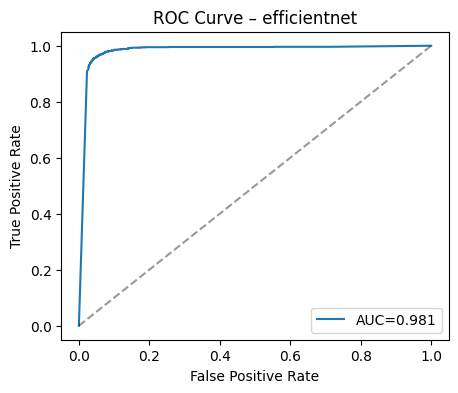

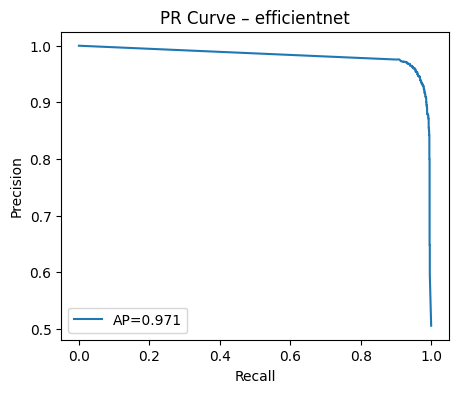


=== SWIN ===
ROC‐AUC: 0.979   PR‐AUC (AP): 0.968
              precision    recall  f1-score   support

   authentic       0.96      0.93      0.94      1520
   imitation       0.93      0.96      0.94      1556

    accuracy                           0.94      3076
   macro avg       0.94      0.94      0.94      3076
weighted avg       0.94      0.94      0.94      3076



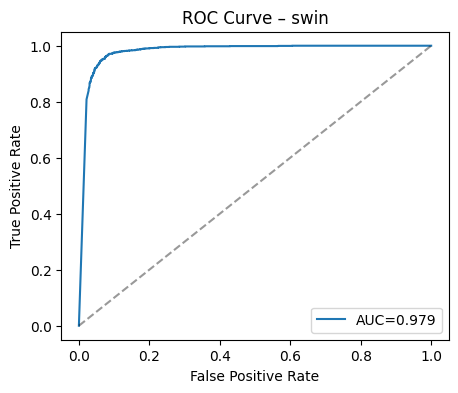

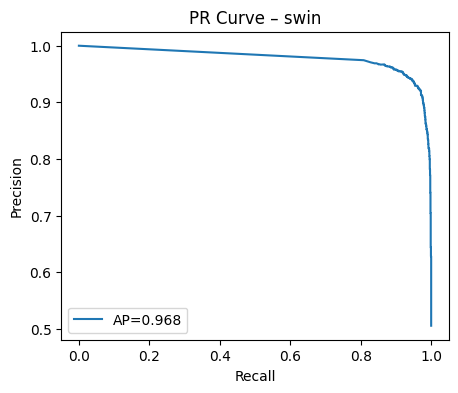

In [10]:
# 9. Detailed Evaluation Metrics & Curves
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")

for name, model in models.items():
    model.to(device).eval()
    y_true, y_scores = [], []

    # Gather ground‐truth & predicted “imitation” probabilities
    with torch.no_grad():
        for x, y, _ in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            probs = F.softmax(logits, dim=1)[:, 1]      # P(imitation)
            y_true.extend(y.cpu().numpy().tolist())
            y_scores.extend(probs.cpu().numpy().tolist())

    # Binarize predictions at 0.5
    y_pred = [1 if p >= 0.5 else 0 for p in y_scores]

    # Compute metrics
    auc = roc_auc_score(y_true, y_scores)
    ap  = average_precision_score(y_true, y_scores)
    print(f"\n=== {name.upper()} ===")
    print(f"ROC‐AUC: {auc:.3f}   PR‐AUC (AP): {ap:.3f}")
    print(classification_report(
        y_true, y_pred,
        target_names=['authentic','imitation']
    ))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
    plt.plot([0,1],[0,1],'k--',alpha=0.4)
    plt.title(f'ROC Curve – {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(); plt.show()

    # Plot Precision–Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(5,4))
    plt.plot(recall, precision, label=f'AP={ap:.3f}')
    plt.title(f'PR Curve – {name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(); plt.show()

## 10. Plotting training metrics for each model
(reads CSV logs and plots train/val loss & val accuracy)

In [11]:
# 8) Painting‐level & Ensemble Evaluation
import numpy as np
import torch.nn.functional as F
from collections import defaultdict, Counter
from sklearn.metrics import classification_report, accuracy_score

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
effnet_model = models['efficientnet'].to(device).eval()
swin_model   = models['swin'].to(device).eval()

# 1. Collect patch‐level data
painting_ids, true_labels = [], []
effnet_probs, swin_probs = [], []

for x, y, pid in val_loader:
    x = x.to(device)
    with torch.no_grad():
        e_logits = effnet_model(x)
        s_logits = swin_model(x)
        e_p = F.softmax(e_logits, dim=1)[:, 1].cpu().numpy()
        s_p = F.softmax(s_logits, dim=1)[:, 1].cpu().numpy()
    painting_ids.extend(pid.numpy())
    true_labels.extend(y.numpy())
    effnet_probs.extend(e_p)
    swin_probs.extend(s_p)

# 2. Aggregate per painting
paintings = defaultdict(list)
for pid, y, p1, p2 in zip(painting_ids, true_labels, effnet_probs, swin_probs):
    paintings[pid].append((y, p1, p2))

painting_true = []
paint_eff_major = []
paint_swin_major = []
paint_ens_major = []
paint_ens_avg = []

for pid, patches in paintings.items():
    y_true = patches[0][0]
    p1_list = [t[1] for t in patches]
    p2_list = [t[2] for t in patches]
    # votes at 0.5
    v1 = [int(p>=0.5) for p in p1_list]
    v2 = [int(p>=0.5) for p in p2_list]
    # ensemble avg‐prob votes
    avg_probs = [(a+b)/2 for a,b in zip(p1_list, p2_list)]
    v_avg = [int(p>=0.5) for p in avg_probs]

    painting_true.append(y_true)
    paint_eff_major.append(Counter(v1).most_common(1)[0][0])
    paint_swin_major.append(Counter(v2).most_common(1)[0][0])
    paint_ens_major.append(Counter(v_avg).most_common(1)[0][0])
    paint_ens_avg.append(int(np.mean(avg_probs)>=0.5))

# 3. Report metrics
print("=== Painting‐level Metrics ===")
for label, preds in [
    ("EffNet‐majority", paint_eff_major),
    ("Swin‐majority", paint_swin_major),
    ("Ensemble‐majority", paint_ens_major),
    ("Ensemble‐avgprob", paint_ens_avg),
]:
    print(f"\n{label}:")
    print("Accuracy:", accuracy_score(painting_true, preds))
    print(classification_report(
        painting_true, preds,
        target_names=['authentic','imitation']
    ))

=== Painting‐level Metrics ===

EffNet‐majority:
Accuracy: 0.9778761061946902
              precision    recall  f1-score   support

   authentic       0.99      0.96      0.98       107
   imitation       0.97      0.99      0.98       119

    accuracy                           0.98       226
   macro avg       0.98      0.98      0.98       226
weighted avg       0.98      0.98      0.98       226


Swin‐majority:
Accuracy: 0.9601769911504425
              precision    recall  f1-score   support

   authentic       0.96      0.95      0.96       107
   imitation       0.96      0.97      0.96       119

    accuracy                           0.96       226
   macro avg       0.96      0.96      0.96       226
weighted avg       0.96      0.96      0.96       226


Ensemble‐majority:
Accuracy: 0.9690265486725663
              precision    recall  f1-score   support

   authentic       0.99      0.94      0.97       107
   imitation       0.95      0.99      0.97       119

    accura

## 11. Saving metrics for each model


In [12]:
import os, json
import matplotlib.pyplot as plt

for model_name in models:
    json_path = f"/kaggle/working/Training Data/{model_name}_results_{now_str}.json"
    if not os.path.exists(json_path):
        print(f"No JSON results for {model_name} at {json_path}")
        continue

    # load our JSON list of dicts
    with open(json_path) as f:
        results = json.load(f)

    train_loss = results["training"]
    val_acc    = results["validation"]
    epochs     = list(range(1, len(train_loss)+1))

    plt.plot(epochs, train_loss, label="train loss")
    plt.plot(epochs, val_acc,    label="val acc")
    plt.legend()
    plt.show()

    #epochs = [r["epoch"] for r in results["training"]]
    #train_loss = [r["loss"]  for r in results["training"]]
    #val_acc    = [r["acc"]   for r in results["validation"]]

    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    ax = axes[0]
    ax.plot(epochs, train_loss, '-o', label="Train Loss")
    ax.set_title(f"{model_name} – Train Loss")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
    ax.grid(True)

    ax = axes[1]
    ax.plot(epochs, val_acc, '-o', color="green", label="Val Acc")
    ax.set_title(f"{model_name} – Val Accuracy")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

No JSON results for efficientnet at /kaggle/working/Training Data/efficientnet_results_2025-09-14_22-13-38.json
No JSON results for swin at /kaggle/working/Training Data/swin_results_2025-09-14_22-13-38.json


## 12. Saving models

In [13]:
import os
import torch

# Ensure the save directory exists
for path in model_save_paths.values():
    os.makedirs(os.path.dirname(path), exist_ok=True)

# Save each model after training
for name, model in models.items():
    torch.save(model.state_dict(), model_save_paths[name])
    print(f"Model weights saved to {model_save_paths[name]}")

Model weights saved to /kaggle/working/model/efficientnet_b5_finetuned_2025-09-14_22-13-38_run1.pth
Model weights saved to /kaggle/working/model/swin_tiny_patch4_window7_224_finetuned_2025-09-14_22-13-38_run1.pth
